#### Relevant Modules

In [ ]:
# Data Analysis
import numpy as np
import pandas as pd
import random
import re
from datetime import datetime

# Visulaisation
import matplotlib.pyplot as plt
import seaborn as sns
import folium
!pip install geopandas
import geopandas as gpd
from branca.colormap import linear
from folium.plugins import MarkerCluster

# Frequent Pattern Mining 
import mlxtend
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth, fpmax, fpcommon
from mlxtend import frequent_patterns as fp

# Machine Learning/Clustering
import sklearn.cluster

# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

# Miscelleanous
import warnings
warnings.filterwarnings("ignore")

#### Importing Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/CS 432 - Data Mining/Project/Accidental_Drug_Related_Deaths_2012-2021.csv')
df

Date      Date Type   Age     Sex                       Race  \
0     05/29/2012  Date of death  37.0    Male                      Black   
1     06/27/2012  Date of death  37.0    Male                      White   
2     03/24/2014  Date of death  28.0    Male                      White   
3     12/31/2014  Date of death  26.0  Female                      White   
4     01/16/2016  Date of death  41.0    Male                      White   
...          ...            ...   ...     ...                        ...   
9197  10/19/2021  Date of death  56.0    Male  Black or African American   
9198  05/04/2021  Date of death  48.0    Male  Black or African American   
9199  05/15/2021  Date of death  59.0    Male                      White   
9200  05/28/2021  Date of death  68.0    Male  Black or African American   
9201  12/24/2021  Date of death  29.0    Male                      White   

                        Ethnicity Residence City Residence County  \
0                             NaN       STAMFORD        FAIRFIELD   
1                             NaN        NORWICH       NEW LONDON   
2                             NaN         HEBRON              NaN   
3                             NaN         BALTIC              NaN   
4                             NaN        SHELTON        FAIRFIELD   
...                           ...            ...              ...   
9197                          NaN       STAMFORD        FAIRFIELD   
9198                          NaN     WEST HAVEN        NEW HAVEN   
9199                          NaN   WETHERSFIELD         HARTFORD   
9200                          NaN       HARTFORD         HARTFORD   
9201  Not Spanish/Hispanic/Latino        SEYMOUR        NEW HAVEN   

     Residence State   Injury City  ... Xylazine Gabapentin Opiate NOS  \
0                NaN      STAMFORD  ...      NaN        NaN        NaN   
1                NaN       NORWICH  ...      NaN        NaN        NaN   
2                NaN        HEBRON  ...      NaN        NaN        NaN   
3                NaN           NaN  ...      NaN        NaN        NaN   
4                 CT       SHELTON  ...      NaN        NaN        NaN   
...              ...           ...  ...      ...        ...        ...   
9197              CT      STAMFORD  ...      NaN        NaN        NaN   
9198              CT    WEST HAVEN  ...      NaN        NaN        NaN   
9199              CT  WETHERSFIELD  ...      NaN          Y        NaN   
9200              CT      HARTFORD  ...      NaN        NaN        NaN   
9201              CT       SEYMOUR  ...        Y        NaN        NaN   

     Heroin/Morph/Codeine Other Opioid Any Opioid Other  \
0                     NaN          NaN        NaN   NaN   
1                     NaN          NaN        NaN   NaN   
2                     NaN          NaN        NaN   NaN   
3                     NaN          NaN        NaN   NaN   
4                     NaN          NaN          Y   NaN   
...                   ...          ...        ...   ...   
9197                  NaN          NaN          Y   PCP   
9198                  NaN          NaN        NaN   NaN   
9199                  NaN          NaN        NaN   NaN   
9200                  NaN          NaN        NaN   NaN   
9201                  NaN          NaN          Y   NaN   

                               ResidenceCityGeo  \
0         STAMFORD, CT\n(41.051924, -73.539475)   
1          NORWICH, CT\n(41.524304, -72.075821)   
2           HEBRON, CT\n(41.658069, -72.366324)   
3           BALTIC, CT\n(41.617221, -72.085031)   
4          SHELTON, CT\n(41.316843, -73.092968)   
...                                         ...   
9197      STAMFORD, CT\n(41.051924, -73.539475)   
9198    WEST HAVEN, CT\n(41.272336, -72.949817)   
9199  WETHERSFIELD, CT\n(41.712487, -72.663607)   
9200      HARTFORD, CT\n(41.765775, -72.673356)   
9201       SEYMOUR, CT\n(41.395594, -73.073581)   

                                  InjuryCityGeo  \
0       

#### Brainstorming EDA

Our Data Matrix ∈ $\mathbb{R}^{N × d}$  where $N = 9202, d = 48$. Due to significantly high number of robots, splitting the dataset column-wise would make our EDA more efficient by relatively quick observations. On that note, blindly splitting would defeat the purpose. Hence, we have decided the following splits.

- `part1` → Contains first 9 attributes of the dataframe containing ID/identification details of each record
- `part2` → Contains 10 attributes relating information regarding the location of the injury of each record
- `part3` → Contains 24 attributes relating to information of which drug was consumed if any from a wide array of choices i.e. the *toxicity report*
- `part4` → Contains last three attributes relating to information of latitude and longitude of locations which will later be used in **Geospatial Visualisation**
You can see a glimpse of each of the parts below

In [3]:
# Splitting the data into 5 parts column wise so that its easier to take all 48 columns into observation
part1 = df.iloc[:, 0:9]
part1

Date      Date Type   Age     Sex                       Race  \
0     05/29/2012  Date of death  37.0    Male                      Black   
1     06/27/2012  Date of death  37.0    Male                      White   
2     03/24/2014  Date of death  28.0    Male                      White   
3     12/31/2014  Date of death  26.0  Female                      White   
4     01/16/2016  Date of death  41.0    Male                      White   
...          ...            ...   ...     ...                        ...   
9197  10/19/2021  Date of death  56.0    Male  Black or African American   
9198  05/04/2021  Date of death  48.0    Male  Black or African American   
9199  05/15/2021  Date of death  59.0    Male                      White   
9200  05/28/2021  Date of death  68.0    Male  Black or African American   
9201  12/24/2021  Date of death  29.0    Male                      White   

                        Ethnicity Residence City Residence County  \
0                             NaN       STAMFORD        FAIRFIELD   
1                             NaN        NORWICH       NEW LONDON   
2                             NaN         HEBRON              NaN   
3                             NaN         BALTIC              NaN   
4                             NaN        SHELTON        FAIRFIELD   
...                           ...            ...              ...   
9197                          NaN       STAMFORD        FAIRFIELD   
9198                          NaN     WEST HAVEN        NEW HAVEN   
9199                          NaN   WETHERSFIELD         HARTFORD   
9200                          NaN       HARTFORD         HARTFORD   
9201  Not Spanish/Hispanic/Latino        SEYMOUR        NEW HAVEN   

     Residence State  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                 CT  
...              ...  
9197              CT  
9198              CT  
9199              CT  
9200              CT  
9201              CT  

[9202 rows x 9 columns]

In [4]:
part2 = df.iloc[:, 10:19] # exclude 20
part2 = pd.concat([part2, df['Manner of Death']], axis = 1)
part2

Injury County Injury State       Injury Place Description of Injury  \
0              NaN           CT          Residence          Used Cocaine   
1              NaN           CT          Residence              Drug Use   
2              NaN           CT          Residence              Drug Use   
3              NaN          NaN                NaN                   NaN   
4              NaN          NaN          Residence              Drug Use   
...            ...          ...                ...                   ...   
9197     FAIRFIELD           CT  Other Indoor Area       Substance abuse   
9198     NEW HAVEN           CT          Residence         Substance Use   
9199      HARTFORD           CT          Residence       Substance Abuse   
9200      HARTFORD           CT          Residence       Substance Abuse   
9201     NEW HAVEN           CT               Home       Substance abuse   

       Death City Death County Death State                  Location  \
0             NaN          NaN         NaN                 Residence   
1         NORWICH   NEW LONDON         NaN                  Hospital   
2     MARLBOROUGH          NaN         NaN                  Hospital   
3          BALTIC   NEW LONDON         NaN                 Residence   
4      BRIDGEPORT          NaN         NaN                  Hospital   
...           ...          ...         ...                       ...   
9197     STAMFORD    FAIRFIELD          CT                     Other   
9198    NEW HAVEN    NEW HAVEN          CT      Hospital - Inpatient   
9199     HARTFORD     HARTFORD          CT  Hospital - ER/Outpatient   
9200     HARTFORD     HARTFORD          CT                 Residence   
9201      SEYMOUR    NEW HAVEN          CT           Decedent's Home   

                 Location if Other Manner of Death  
0                              NaN        Accident  
1                              NaN        Accident  
2                              NaN        Accident  
3                              NaN        Accident  
4                              NaN        Accident  
...                            ...             ...  
9197  Hallway at friend's residene        Accident  
9198                           NaN        Accident  
9199                           NaN        Accident  
9200                           NaN        Accident  
9201                           NaN        Accident  

[9202 rows x 10 columns]

In [5]:
part3 = pd.concat([df.iloc[:, 19] ,df.iloc[:, 22:45]], axis = 1)
part3

Cause of Death Heroin  \
0                                      Cocaine Toxicity    NaN   
1                                       Heroin Toxicity      Y   
2                                   Heroin Intoxication      Y   
3                             Acute Heroin Intoxication      Y   
4                           Acute Fentanyl Intoxication    NaN   
...                                                 ...    ...   
9197  Acute Intoxication by the Combined Effects of ...    NaN   
9198  Complications of Acute Substance Intoxication ...    NaN   
9199  Acute Intoxication by the Combined Effects of ...    NaN   
9200                         Acute Cocaine Intoxication    NaN   
9201  Acute Intoxication by the Combined Effects of ...    NaN   

     Heroin death certificate (DC) Cocaine Fentanyl Fentanyl Analogue  \
0                              NaN       Y      NaN               NaN   
1                              NaN     NaN      NaN               NaN   
2                              NaN     NaN      NaN               NaN   
3                              NaN     NaN      NaN               NaN   
4                              NaN     NaN        Y               NaN   
...                            ...     ...      ...               ...   
9197                           NaN       Y      NaN               NaN   
9198                           NaN       Y      NaN               NaN   
9199                           NaN       Y      NaN               NaN   
9200                           NaN       Y      NaN               NaN   
9201                           NaN     NaN        Y               NaN   

     Oxycodone Oxymorphone Ethanol Hydrocodone  ... Tramad Hydromorphone  \
0          NaN         NaN     NaN         NaN  ...    NaN           NaN   
1          NaN         NaN     NaN         NaN  ...    NaN           NaN   
2          NaN         NaN     NaN         NaN  ...    NaN           NaN   
3          NaN         NaN     NaN         NaN  ...    NaN           NaN   
4          NaN         NaN     NaN         NaN  ...    NaN           NaN   
...        ...         ...     ...         ...  ...    ...           ...   
9197         Y         NaN     NaN         NaN  ...    NaN           NaN   
9198       NaN         NaN       Y         NaN  ...    NaN           NaN   
9199       NaN         NaN     NaN         NaN  ...    NaN           NaN   
9200       NaN         NaN     NaN         NaN  ...    NaN           NaN   
9201       NaN         NaN     NaN         NaN  ...    NaN           NaN   

     Morphine (Not Heroin) Xylazine Gabapentin Opiate NOS  \
0                      NaN      NaN        NaN        NaN   
1                      NaN      NaN        NaN        NaN   
2                      NaN      NaN        NaN        NaN   
3                      NaN      NaN        NaN        NaN   
4                      NaN      NaN        NaN        NaN   
...                    ...      ...        ...        ...   
9197                   NaN      NaN        NaN        NaN   
9198                   NaN      NaN        NaN        NaN   
9199                   NaN      NaN          Y        NaN   
9200                   NaN      NaN        NaN        NaN   
9201                   NaN        Y        NaN        NaN   

     Heroin/Morph/Codeine Other Opioid Any Opioid Other  
0                     NaN          NaN        NaN   NaN  
1                     NaN          NaN        NaN   NaN  
2                     NaN          NaN        NaN   NaN  
3                     NaN          NaN        NaN   NaN  
4                     NaN          NaN          Y   NaN  
...                   ...          ...        ...   ...  
9197                  NaN          NaN          Y   PCP  
9198                  NaN          NaN        NaN   NaN  
9199                  NaN          NaN        NaN   NaN  
9200                  NaN          NaN        NaN   NaN  
9201                  NaN          NaN          Y   NaN  

[9202 rows x 24 columns]

In [6]:
part4 = df.iloc[:, 45:]
part4

ResidenceCityGeo  \
0         STAMFORD, CT\n(41.051924, -73.539475)   
1          NORWICH, CT\n(41.524304, -72.075821)   
2           HEBRON, CT\n(41.658069, -72.366324)   
3           BALTIC, CT\n(41.617221, -72.085031)   
4          SHELTON, CT\n(41.316843, -73.092968)   
...                                         ...   
9197      STAMFORD, CT\n(41.051924, -73.539475)   
9198    WEST HAVEN, CT\n(41.272336, -72.949817)   
9199  WETHERSFIELD, CT\n(41.712487, -72.663607)   
9200      HARTFORD, CT\n(41.765775, -72.673356)   
9201       SEYMOUR, CT\n(41.395594, -73.073581)   

                                  InjuryCityGeo  \
0         STAMFORD, CT\n(41.051924, -73.539475)   
1          NORWICH, CT\n(41.524304, -72.075821)   
2           HEBRON, CT\n(41.658069, -72.366324)   
3                   CT\n(41.575155, -72.738288)   
4          SHELTON, CT\n(41.316843, -73.092968)   
...                                         ...   
9197      STAMFORD, CT\n(41.051924, -73.539475)   
9198    WEST HAVEN, CT\n(41.272336, -72.949817)   
9199  WETHERSFIELD, CT\n(41.712487, -72.663607)   
9200      HARTFORD, CT\n(41.765775, -72.673356)   
9201       SEYMOUR, CT\n(41.395594, -73.073581)   

                                  DeathCityGeo  
0                  CT\n(41.575155, -72.738288)  
1         Norwich, CT\n(41.524304, -72.075821)  
2     Marlborough, CT\n(41.632043, -72.461309)  
3          Baltic, CT\n(41.617221, -72.085031)  
4      Bridgeport, CT\n(41.179195, -73.189476)  
...                                        ...  
9197     Stamford, CT\n(41.051924, -73.539475)  
9198    New Haven, CT\n(41.308252, -72.924161)  
9199     Hartford, CT\n(41.765775, -72.673356)  
9200     Hartford, CT\n(41.765775, -72.673356)  
9201      Seymour, CT\n(41.395594, -73.073581)  

[9202 rows x 3 columns]

#### Moving On

From here on out, though we will be cleaning the data where possible, we will be particularly interested in how we can extract useful insights, patterns and most importantly how we can relate that to our next task of `Frequent Pattern Mining and Clustering`.

**Note:** Any hypothesis claims made in this regard for now will be based of our EDA and hopefully be backed up by out analysis in `Deliverable 2`

In [7]:
# Checking types of attributes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9202 entries, 0 to 9201
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           9202 non-null   object 
 1   Date Type                      9202 non-null   object 
 2   Age                            9200 non-null   float64
 3   Sex                            9194 non-null   object 
 4   Race                           9178 non-null   object 
 5   Ethnicity                      1287 non-null   object 
 6   Residence City                 8813 non-null   object 
 7   Residence County               8160 non-null   object 
 8   Residence State                7426 non-null   object 
 9   Injury City                    9024 non-null   object 
 10  Injury County                  5914 non-null   object 
 11  Injury State                   6290 non-null   object 
 12  Injury Place                   9100 non-null   o

In [8]:
# Ethnicity has more than 80% missing values hence its sensible to remove it.
df_filtered = df.drop('Ethnicity', axis = 1)

# Though several other variables also have high number of missing values like the attributes representing the different drug types, its likely due to their intrinsic nature where a person is less likely to be intoxicated
# more than one drug. Therefore, let's check this hypothesis. If its true, we will replace the NaN's with 0 where the drug is absent and 1 where the drug is present. However, if for a small percentage it does not hold, we might 
# be able to ignore it

#### Insights/Thoughts so far
- `Age` is the only numeric variable so we might be interested in what variables we can encode to make our analysis more meaningful
- `Ethnicity` has more than 80% missing values hence its sensible to remove it.
- Though several other variables also have high number of missing values like the attributes representing the different drug types, it maybe due to their intrinsic nature where a person is less likely to be intoxicated
by more than one drug. Therefore, let's check this hypothesis.


In [9]:
# Let's consider the dataset corresponding to the toxicity report i.e. attributes ranging from "Heroin" -> "Other"
tox_report = part3.drop(['Cause of Death', 'Heroin death certificate (DC)'], axis = 1)
tox_report.head()

Heroin Cocaine Fentanyl Fentanyl Analogue Oxycodone Oxymorphone Ethanol  \
0    NaN       Y      NaN               NaN       NaN         NaN     NaN   
1      Y     NaN      NaN               NaN       NaN         NaN     NaN   
2      Y     NaN      NaN               NaN       NaN         NaN     NaN   
3      Y     NaN      NaN               NaN       NaN         NaN     NaN   
4    NaN     NaN        Y               NaN       NaN         NaN     NaN   

  Hydrocodone Benzodiazepine Methadone  ... Tramad Hydromorphone  \
0         NaN            NaN       NaN  ...    NaN           NaN   
1         NaN            NaN       NaN  ...    NaN           NaN   
2         NaN            NaN       NaN  ...    NaN           NaN   
3         NaN            NaN       NaN  ...    NaN           NaN   
4         NaN            NaN       NaN  ...    NaN           NaN   

  Morphine (Not Heroin) Xylazine Gabapentin Opiate NOS Heroin/Morph/Codeine  \
0                   NaN      NaN        NaN        NaN                  NaN   
1                   NaN      NaN        NaN        NaN                  NaN   
2                   NaN      NaN        NaN        NaN                  NaN   
3                   NaN      NaN        NaN        NaN                  NaN   
4                   NaN      NaN        NaN        NaN                  NaN   

  Other Opioid Any Opioid Other  
0          NaN        NaN   NaN  
1          NaN        NaN   NaN  
2          NaN        NaN   NaN  
3          NaN        NaN   NaN  
4          NaN          Y   NaN  

[5 rows x 22 columns]

In [10]:
# Now let's check our hypothesis. Check whether each row contains more than one instance of "Y".
tox_report['count'] = (tox_report == 'Y').sum(axis = 1)
tox_report

Heroin Cocaine Fentanyl Fentanyl Analogue Oxycodone Oxymorphone Ethanol  \
0       NaN       Y      NaN               NaN       NaN         NaN     NaN   
1         Y     NaN      NaN               NaN       NaN         NaN     NaN   
2         Y     NaN      NaN               NaN       NaN         NaN     NaN   
3         Y     NaN      NaN               NaN       NaN         NaN     NaN   
4       NaN     NaN        Y               NaN       NaN         NaN     NaN   
...     ...     ...      ...               ...       ...         ...     ...   
9197    NaN       Y      NaN               NaN         Y         NaN     NaN   
9198    NaN       Y      NaN               NaN       NaN         NaN       Y   
9199    NaN       Y      NaN               NaN       NaN         NaN     NaN   
9200    NaN       Y      NaN               NaN       NaN         NaN     NaN   
9201    NaN     NaN        Y               NaN       NaN         NaN     NaN   

     Hydrocodone Benzodiazepine Methadone  ... Hydromorphone  \
0            NaN            NaN       NaN  ...           NaN   
1            NaN            NaN       NaN  ...           NaN   
2            NaN            NaN       NaN  ...           NaN   
3            NaN            NaN       NaN  ...           NaN   
4            NaN            NaN       NaN  ...           NaN   
...          ...            ...       ...  ...           ...   
9197         NaN            NaN       NaN  ...           NaN   
9198         NaN            NaN       NaN  ...           NaN   
9199         NaN            NaN       NaN  ...           NaN   
9200         NaN            NaN       NaN  ...           NaN   
9201         NaN            NaN         Y  ...           NaN   

     Morphine (Not Heroin) Xylazine Gabapentin Opiate NOS  \
0                      NaN      NaN        NaN        NaN   
1                      NaN      NaN        NaN        NaN   
2                      NaN      NaN        NaN        NaN   
3                      NaN      NaN        NaN        NaN   
4                      NaN      NaN        NaN        NaN   
...                    ...      ...        ...        ...   
9197                   NaN      NaN        NaN        NaN   
9198                   NaN      NaN        NaN        NaN   
9199                   NaN      NaN          Y        NaN   
9200                   NaN      NaN        NaN        NaN   
9201                   NaN        Y        NaN        NaN   

     Heroin/Morph/Codeine Other Opioid Any Opioid Other count  
0                     NaN          NaN        NaN   NaN     1  
1                     NaN          NaN        NaN   NaN     1  
2                     NaN          NaN        NaN   NaN     1  
3                     NaN          NaN        NaN   NaN     1  
4                     NaN          NaN          Y   NaN     2  
...                   ...          ...        ...   ...   ...  
9197                  NaN          NaN          Y   PCP     3  
9198                  NaN          NaN        NaN   NaN     2  
9199                  NaN          NaN        NaN   NaN     2  
9200                  NaN          NaN        NaN   NaN     1  
9201                  NaN          NaN          Y   NaN     4  

[9202 rows x 23 columns]

In [11]:
# Now let's check the value_counts of count
counts = tox_report['count'].value_counts()
counts ## showing number of drugs in the blood at the time of death for e.g, 2446 cases where the person was in consumption of 3 substances

3     2446
4     1934
2     1893
5     1132
1     1102
6      440
7      128
0       92
8       29
9        4
10       2
Name: count, dtype: int64

**Since our hypothesis of there being a unique drug consumed for each observation is likely not true, it does pave the way for what sort of analysis can be carried out in the latter part especially frequent pattern mining
where we will be looking out for which types of drugs are most commonly together. Therefore for proper analysis, let's convert the "Y" to 1 and the nan's to 0.**

In [12]:
tox_report.iloc[:, :-1] = pd.DataFrame((np.where(tox_report.iloc[:, :-1] == 'Y', 1, 0)), columns = tox_report.columns[:-1])
tox_report

Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
0          0        1         0                  0          0            0   
1          1        0         0                  0          0            0   
2          1        0         0                  0          0            0   
3          1        0         0                  0          0            0   
4          0        0         1                  0          0            0   
...      ...      ...       ...                ...        ...          ...   
9197       0        1         0                  0          1            0   
9198       0        1         0                  0          0            0   
9199       0        1         0                  0          0            0   
9200       0        1         0                  0          0            0   
9201       0        0         1                  0          0            0   

      Ethanol  Hydrocodone  Benzodiazepine  Methadone  ...  Hydromorphone  \
0           0            0               0          0  ...              0   
1           0            0               0          0  ...              0   
2           0            0               0          0  ...              0   
3           0            0               0          0  ...              0   
4           0            0               0          0  ...              0   
...       ...          ...             ...        ...  ...            ...   
9197        0            0               0          0  ...              0   
9198        1            0               0          0  ...              0   
9199        0            0               0          0  ...              0   
9200        0            0               0          0  ...              0   
9201        0            0               0          1  ...              0   

      Morphine (Not Heroin)  Xylazine  Gabapentin  Opiate NOS  \
0                         0         0           0           0   
1                         0         0           0           0   
2                         0         0           0           0   
3                         0         0           0           0   
4                         0         0           0           0   
...                     ...       ...         ...         ...   
9197                      0         0           0           0   
9198                      0         0           0           0   
9199                      0         0           1           0   
9200                      0         0           0           0   
9201                      0         1           0           0   

      Heroin/Morph/Codeine  Other Opioid  Any Opioid  Other  count  
0                        0             0           0      0      1  
1                        0             0           0      0      1  
2                        0             0           0      0      1  
3                        0             0           0      0      1  
4                        0             0           1      0      2  
...                    ...           ...         ...    ...    ...  
9197                     0             0           1      0      3  
9198                     0             0           0      0      2  
9199                     0             0           0      0      2  
9200                     0             0           0      0      1  
9201                     0             0           1      0      4  

[9202 rows x 23 columns]

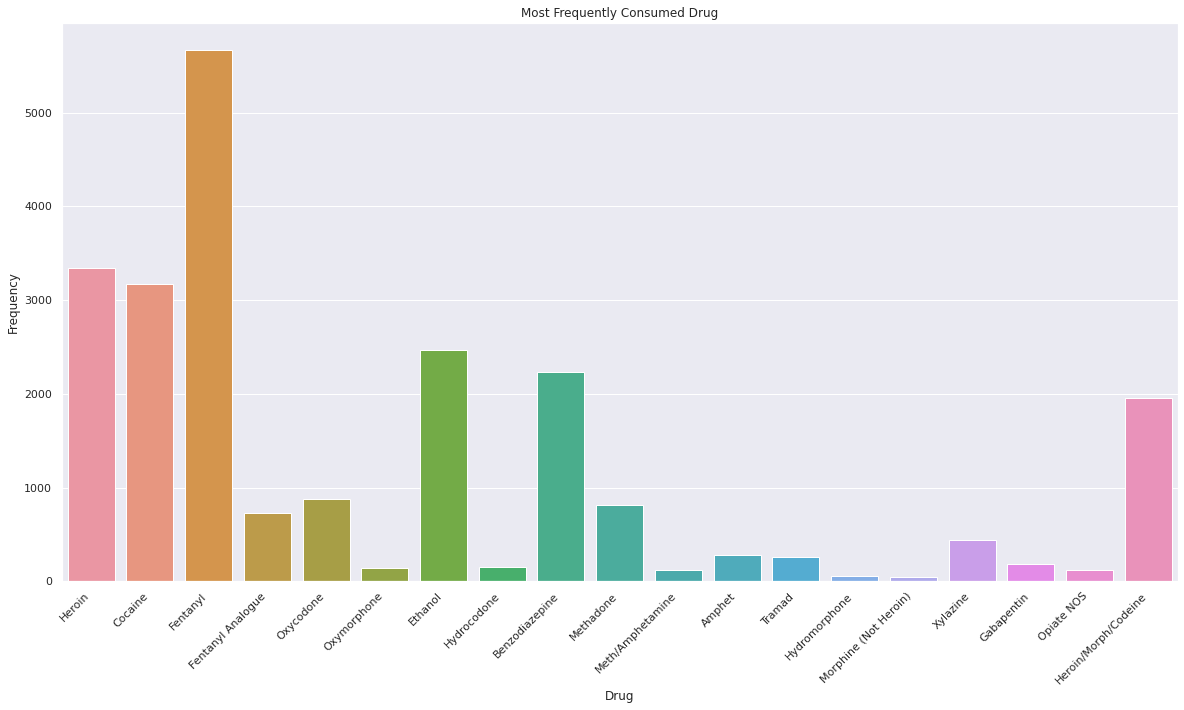

In [14]:
# Let's visualise the most common drug by addign instances of 1's column wise for column between Heroin -> Heroin/Morph/Codeine
common = []
for col in tox_report.columns[:-4]:
  common.append(tox_report[col].sum(axis = 0))

sns.set(rc={'figure.figsize':(20,10.27)})

fig, axes = plt.subplots()

ax1 = sns.barplot(x = tox_report.columns[:-4], y = common)
ax1.set(title = 'Most Frequently Consumed Drug', xlabel = "Drug", ylabel = "Frequency")
axes.set_xticklabels(axes.get_xticklabels(), rotation = 45, ha = 'right')
plt.show()

# We observe that Fentanyl is the most common consumed drug followed by Heroin and Cocaine

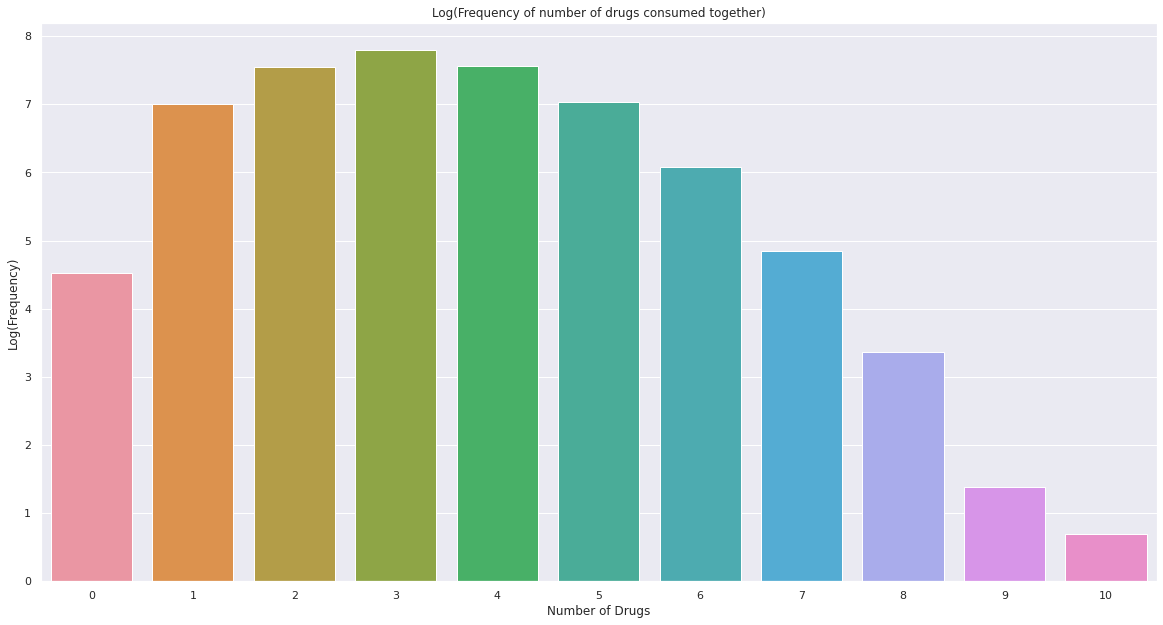

In [15]:
# Let's sort the count's variable index wise and visualize it.
# Since we are primarily concerned with the relative ratios of the frequency rather than the actual values we use a log scale
counts.sort_index(inplace = True)
sns.set(rc={'figure.figsize':(20,10.27)})

fig, axes = plt.subplots()

ax1 = sns.barplot(x = counts.index, y = np.log(counts.values))
ax1.set(title = 'Log(Frequency of number of drugs consumed together)', xlabel = "Number of Drugs", ylabel = "Log(Frequency)")
plt.show()

#### Analysis, some more ideas and Notations
- With our bar graph for most common consumed drug, we can see crystal clear that **Fentanyl** is the most used drug, followed by Heroin and Cocaine. To start of our planning for our next deliverable, we can link the *interestingness measure* like **support** (denoted by $supp$) to our above observation. More specifically, $supp(Fentanyl) > supp(Cocaine) + supp(Heroin)$

- Moreover, in our above visualization, we typically see that as the number of drugs are increasing, the frequency increases up to a point (till 3) then it smoothly declines. For now, we can take this at face value but later, hopefully we are able to extract some more information, we may be able to explain this behaviour. For convieniance purpose, we will be denoting this variable as `n`. 
and $supp(n)$ falls as n increases (denoted by the *hill-shaped distribution*)

- Now that we have visualised counts of the number of drugs present at the time of death, we are particularly interested in its patterns/relationships with other key variables. 
- Visualisation can sometimes help uncover ideas/patterns that may not be otherwise visible looking at the counts. 
- We will be making good use of **bar graphs** when undertaking the task of extracting `n's` relationship with some *key variables* determined by our intution. 
- These key variables include but not limited to the following:
  - `Sex`
  - `Race`
  - `Residence City`
  - `Cause of Death`

**Note:** There's no specific way to go about **EDA** in general practices so we will not be fixated on these 4 attributes only. Wherever our insights lead our thoughts, we will most likely venture there, hence its likely that we will not be visiting them in order. 

To begin of our analysis, we will have to carefully look into whether there is any hindrance from missing values. However, at the same time, so that we don't divert from the actual purpose which is gathering meaningful insights from the data, let's randomly assign each of the categories for each missing value for each attribute.

In [16]:
# Filling missing values with -1 so that those can be accessed
df = df.fillna(-1)

# Making a function which does the above mentioned technique
def nafill(attribute):
  categories = df[attribute].unique()[(df[attribute].unique() != -1)]
  df[attribute] = np.where(df[attribute] == -1, np.random.choice(categories), df[attribute])


In [17]:
# Using the function defined on the 4 categories
nafill('Sex')
nafill('Race')
nafill('Residence City')
nafill('Cause of Death')

In [18]:
# Making a function which when given an attribute plots n grouped by its categories.
# sns.set(rc={'figure.figsize':(20,12.27)})

# Takes the attribute, the data from which we want to plot (maybe a subset hence different arguement than "original" which is our df we loaded)
# Takes a boolean "check" which specifies whether grouping by the variable is required or not. "uni" is a list of the unique attributes from which we want to group n by. Again, might be a subset of the complete list
# scale specifies whether to use log scale or not
def graph(attribute, filter, original, check, uni, scale):

  # concat if we need grouping
  if check == True:
    filter_tox = pd.concat([filter, original[attribute]], axis = 1)
  # simply use the grouped data
  else:
    filter_tox = filter

  # Get filtered counts by attribute
  group_filter = filter_tox.groupby([attribute])
  data = group_filter['count'].value_counts()

  # Plot
  unique = uni
  sns.set(rc={'figure.figsize':(10,5.27)})
  fig, axes = plt.subplots()
  for i in range(len(unique)):
    ## Getting the xaxis using the grouped data, sorting it for better visualisation and log-scaling if check == True
    xaxis = (data.loc[unique[i]].sort_index()).index
    if scale == True:
      yaxis = np.log(data.loc[unique[i]].sort_index().values)
      ax1 = sns.barplot(x = xaxis, y = yaxis)
      ax1.set(title = f'Log(Frequency of number of drugs consumed together) By {attribute} ({unique[i]})', xlabel = "Number of Drugs", ylabel = "Log(Frequency)")
    else:
      yaxis = (data.loc[unique[i]].sort_index().values)
      ax1 = sns.barplot(x = xaxis, y = yaxis)
      ax1.set(title = f'Frequency of number of drugs consumed together By {attribute} ({unique[i]})', xlabel = "Number of Drugs", ylabel = "Frequency")
    
    plt.show()


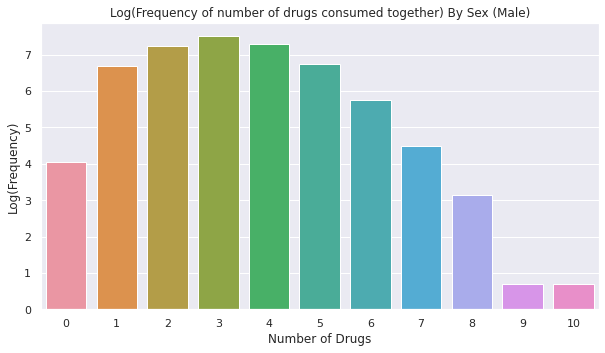

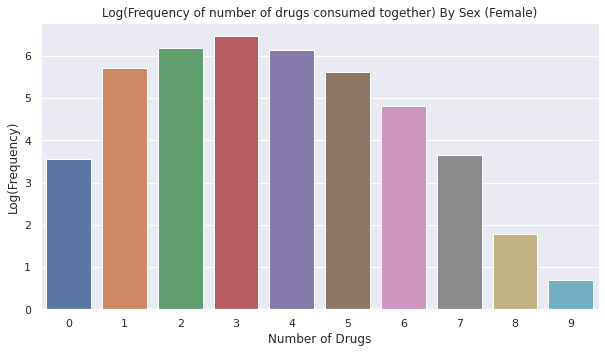

In [19]:
# Let's do it for Gender
graph('Sex', tox_report, df, True, df['Sex'].unique(), True)

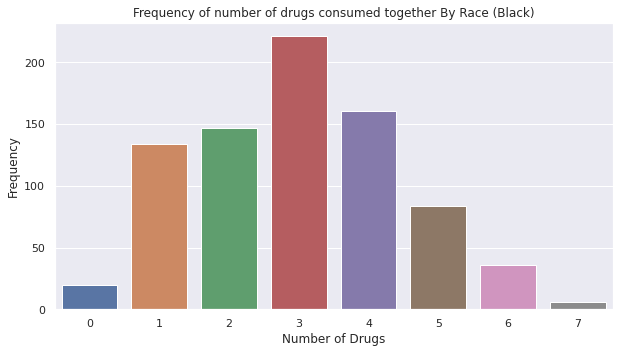

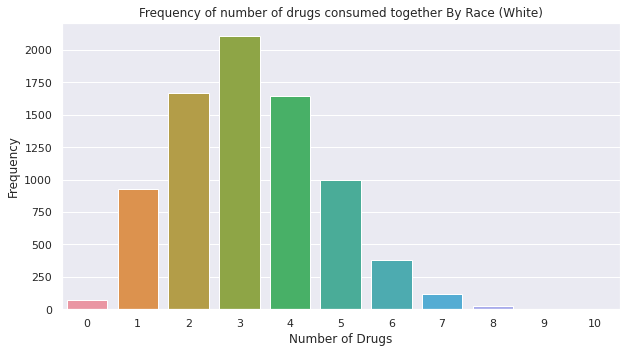

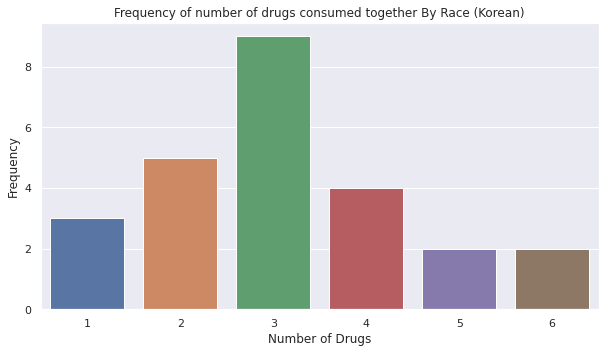

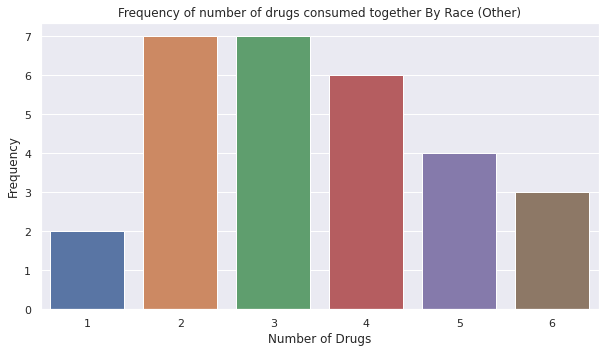

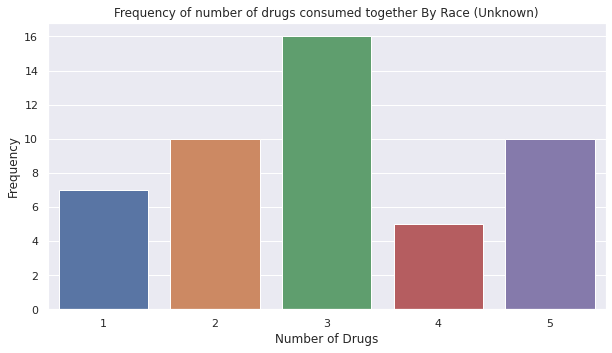

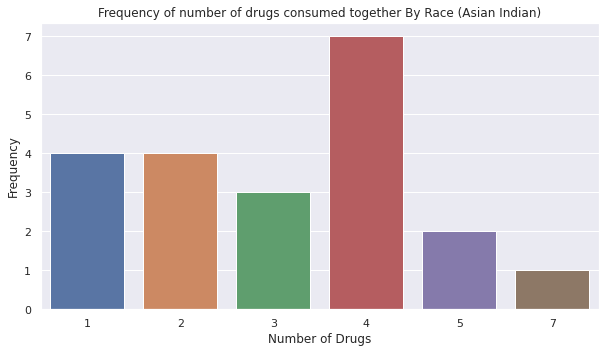

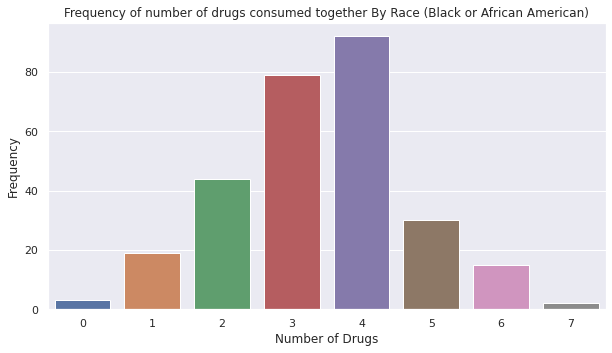

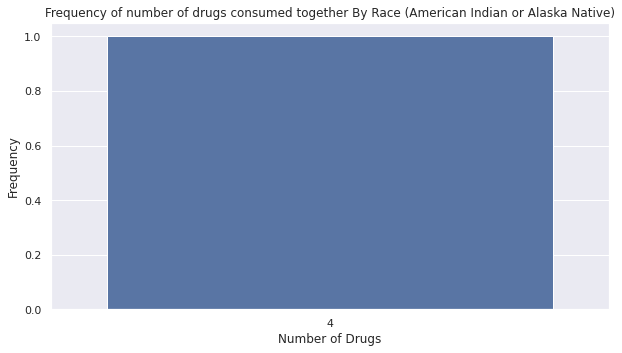

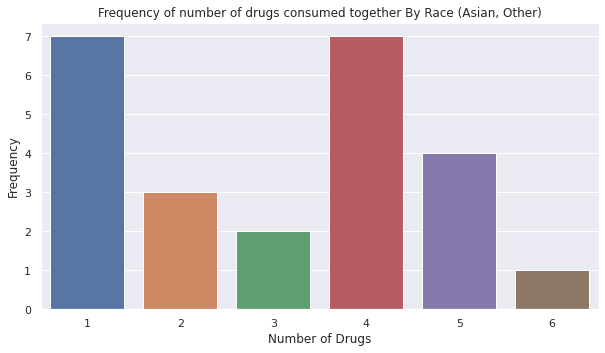

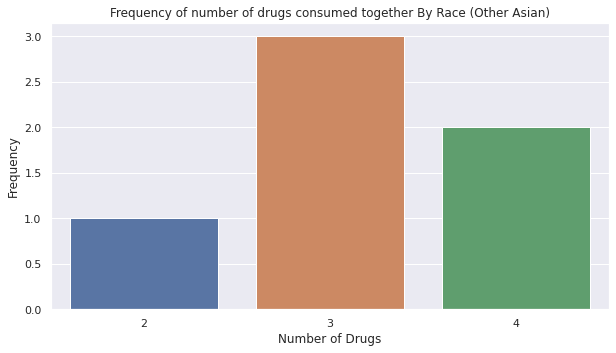

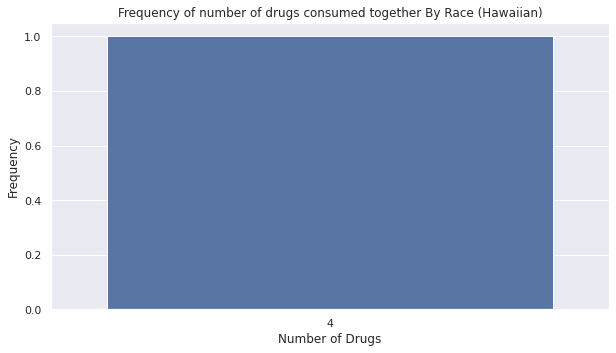

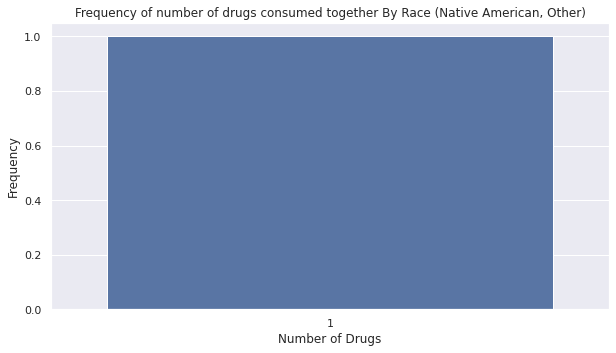

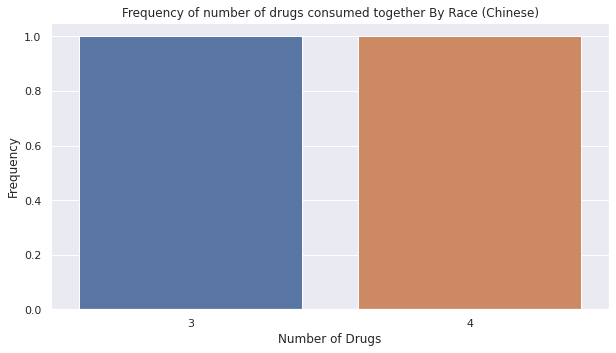

In [20]:
# Now let's do it for Race
graph('Race', tox_report, df, True, df['Race'].unique(), False)

#### Insights

- With regards to our graph grouped with `Race`, we see that "Chinese", "Korean", "Native American, Other", "Hawaiian", "American Indian or Alaska Native" dont seem to control much variation in $n$, Moreover,  "Unknown", "Asian", "Other", "Asian Indian", "Asian, Other" do somewhat vary with $n$ and follow the *hill-shaped distribution*. 

- But most importantly, blacks and even more so whites, overwhelm all categories with frequency ranging in the hundreds to even thousands. Therefore, for large $n$ we expect $conf(n → White) > conf(n → Black) > conf(n → a_{i})$ where $a_{i}$ denotes all other categoires and $conf$ denotes the *interestingness measure* **confidence**

- Though generally we can see that $supp(M, n) > supp(F, n)$ ∀ $n$, both Female and Males, though shifted a little, follow the same distributon. Hence `Sex` is not that pertinent to the explanation of the hill-shaped bar graph we saw solely for $n$ above. We still have to explain that. 

- Due to the similar distribution, this further implies that the **confidence** $conf(Gender → n)$ decreases as n increases for both as the distribution is similar. And since $supp(M, n) > supp(F, n)$ ∀ n, $conf(M → n) > conf(F → n)$  ∀ $n$. For more mathematically inclined people, this simply means that the *probability* of the person being male for **large** $n$ is greater than of female but ever so somewhat decreasing. 

- Seeing such patterns in $n$ could be a direction in which we should focus on. From here on, we will be particularly interested in how our analysis behaves under the scaling (increasing or decreasing) of $n$ 

- When talking about our attributes relationship with $n$, it's hard not to consider the correlation heatmap of `part3` i.e. our toxicity report

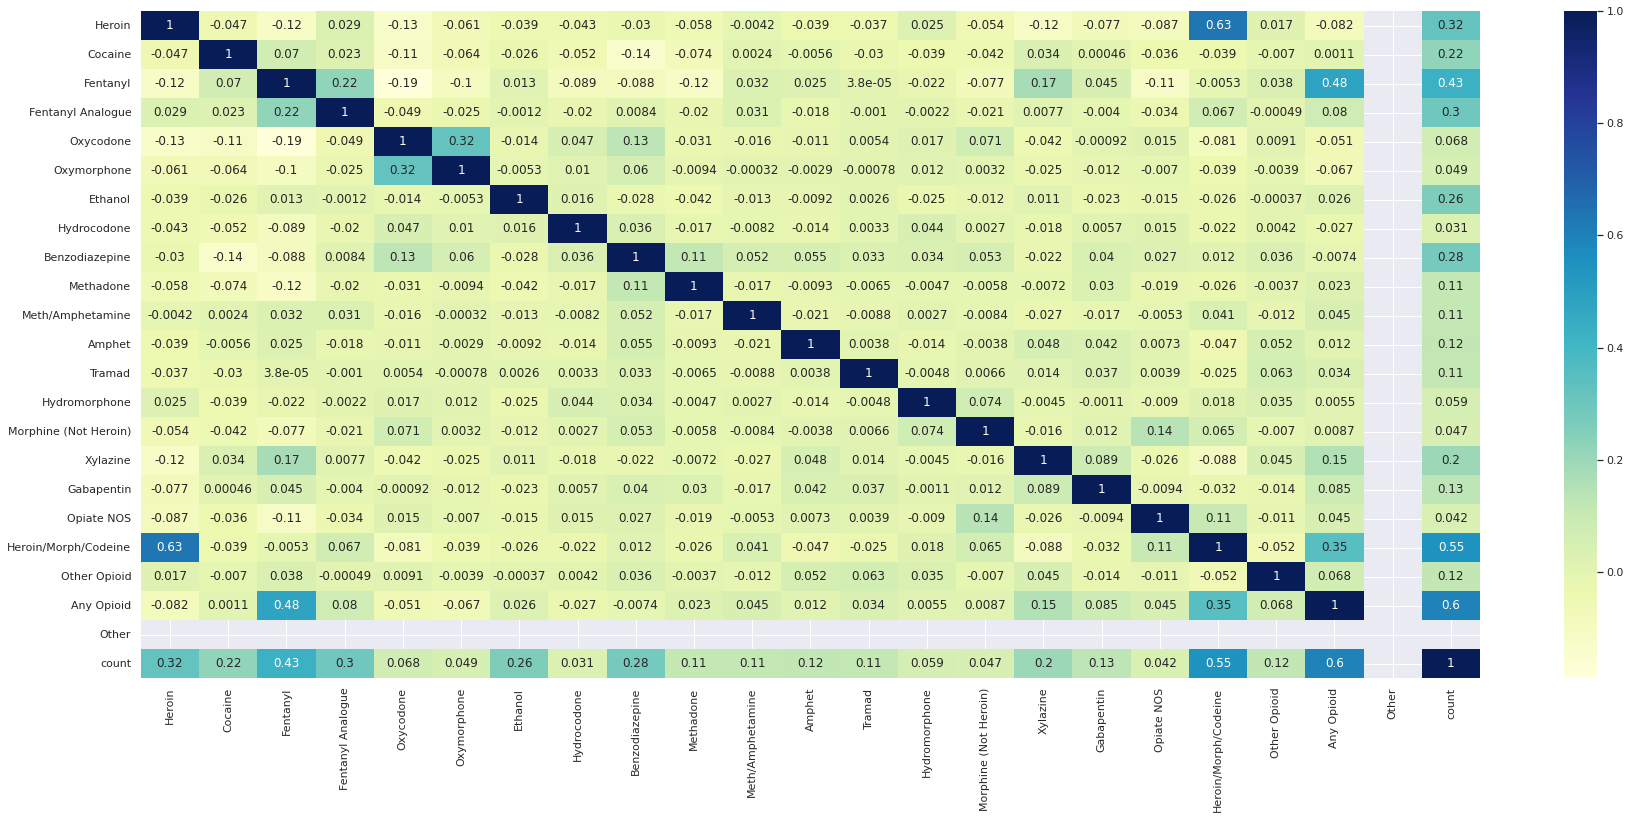

In [21]:
sns.set(rc={'figure.figsize':(30,12.27)})

dataplot = sns.heatmap(tox_report.corr(), cmap="YlGnBu", annot = True)

#### $n$ and its counterparts

- One interesting observation could be that almost every substance is negatively correlated of the order $10^{-2}$ i.e. uncorrelated with each other aside from some 1-2 obvious ones like Heroin with Heatroin/Morph/Codeine which is self-explanatory. 
- This could imply that though there were a significant of joint consumption of substances, it was completely random and does not have any hidden pattern. 

- In the analysis we will be looking out for interestingness measures that could help solidify this belief. One such measure could be $Cosine, Jaccard$ which help quantifying correlation. If we get a similar result then its likely that our hypothesis is correct.

- Coming back to our main topic which was $n$, we see that $n$ is most correlated with the *Fentanyl* and *Heroine/Morphine/Codeine* which does shed light on how this $n$ behaves. We will be speciifcally looking out for the former substance since standalone has great effect on $n$ than the combined effect of the three in the latter

- Leading from these substances comes the attributes `Cause of Death` and `Manner of Death`. So let's explore them. This could help us identify to what extent is substance abuse influencing the deaths. Let's explore them a bit before moving on to the task of extracting their relationship



In [22]:
df['Manner of Death'].unique()

array(['Accident', 'Pending', 'accident', -1, 'ACCIDENT', 'Natural'],
      dtype=object)

In [23]:
# Recall we had converted the na values to -1 before. One thing straight away is the duplicaton of the entry Accident. Let's fix that
df['Manner of Death'] = np.where(df['Manner of Death'] == 'ACCIDENT', 'Accident', df['Manner of Death'])
df['Manner of Death'] = np.where(df['Manner of Death'] == 'accident', 'Accident', df['Manner of Death'])
df['Manner of Death'].unique()

array(['Accident', 'Pending', -1, 'Natural'], dtype=object)

In [24]:
# Let's check their counts
df['Manner of Death'].value_counts()

Accident    9178
Pending       14
-1             9
Natural        1
Name: Manner of Death, dtype: int64

In [25]:
# Negligible counts of Pending, Missing Values and Natural Combined compared to Accident. Leads to believe that we can safely randomly fill the missing values as done before. Surely there will be a presence of bias as "Accident"
# will most likely be the correct replacement, but that defeats the purpose of the attribute if all values are the same. Therefore, due to minimal presence of the other categories, it will still be represented more or less the
# same w.r.t to the others but at the same time, we retain an attribute. 
nafill('Manner of Death')
df['Manner of Death'].unique()

array(['Accident', 'Pending', 'Natural'], dtype=object)

In [26]:
df['Manner of Death'].value_counts()
# Due to the negligible values of other categories in the "Manner of Death", we will ignore them and move on with our analysis with "Accident" being the most likely end result.

Accident    9178
Pending       14
Natural       10
Name: Manner of Death, dtype: int64

In [27]:
df['Cause of Death'].unique()
# Nearly 6000 unique values

array(['Cocaine Toxicity', 'Heroin Toxicity', 'Heroin Intoxication', ...,
       'Complications of Acute Substance Intoxication Including Cocaine and Alcohol',
       'Acute Intoxication by the Combined Effects of Cocaine, Gabapentin, and Citalopram',
       'Acute Intoxication by the Combined Effects of Fentanyl, Xylazine, and Methadone'],
      dtype=object)

In [28]:
# Out of 6000 causes, only a few(around 4) with Acute Fentanyl Intoxication being the most common have counts greater than 100. This could imply that the single itemset of Fentanyl could have the highest support,
# which is inline with our observation of Fentanyl being the sole influencer of n in the correlation heatmap made above
uniq = list((df['Cause of Death'].value_counts()[(df['Cause of Death'].value_counts() >= 100)]).index)
uniq

['Acute Fentanyl Intoxication',
 'Multiple Drug Toxicity',
 'Heroin Intoxication',
 'Acute Heroin Intoxication']

In [29]:
# Let's recall our discussion over how various factors can affect n. Let's draw its graph, but filtering Cause of Death by the 4 categories above
filtered_cause = df['Cause of Death'][(df['Cause of Death'] == 'Acute Fentanyl Intoxication') |  (df['Cause of Death'] == 'Multiple Drug Toxicity') | (df['Cause of Death'] == 'Heroin Intoxication') | 
                                      (df['Cause of Death'] == 'Acute Heroin Intoxication')]
# sort index                                      
filtered_cause.sort_index(inplace = True)
filtered_cause

2               Heroin Intoxication
3         Acute Heroin Intoxication
4       Acute Fentanyl Intoxication
9               Heroin Intoxication
10      Acute Fentanyl Intoxication
                   ...             
9027    Acute Fentanyl Intoxication
9046    Acute Fentanyl Intoxication
9140    Acute Fentanyl Intoxication
9185    Acute Fentanyl Intoxication
9190    Acute Fentanyl Intoxication
Name: Cause of Death, Length: 798, dtype: object

In [30]:
# Now let's get the count variable along with this with the same indices
# Let's create a copy of tox_report before we modify it
tox_copy = tox_report.copy()
tox_copy = tox_copy.loc[filtered_cause.index]
tox_copy

Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
2          1        0         0                  0          0            0   
3          1        0         0                  0          0            0   
4          0        0         1                  0          0            0   
9          1        0         0                  0          0            0   
10         0        0         1                  0          0            0   
...      ...      ...       ...                ...        ...          ...   
9027       0        0         1                  0          0            0   
9046       0        0         1                  0          0            0   
9140       0        1         1                  0          0            0   
9185       0        0         1                  0          0            0   
9190       0        0         1                  0          0            0   

      Ethanol  Hydrocodone  Benzodiazepine  Methadone  ...  Hydromorphone  \
2           0            0               0          0  ...              0   
3           0            0               0          0  ...              0   
4           0            0               0          0  ...              0   
9           0            0               0          0  ...              0   
10          0            0               0          0  ...              0   
...       ...          ...             ...        ...  ...            ...   
9027        0            0               0          0  ...              0   
9046        0            0               0          0  ...              0   
9140        0            0               0          0  ...              0   
9185        0            0               0          0  ...              0   
9190        0            0               0          0  ...              0   

      Morphine (Not Heroin)  Xylazine  Gabapentin  Opiate NOS  \
2                         0         0           0           0   
3                         0         0           0           0   
4                         0         0           0           0   
9                         0         0           0           0   
10                        0         0           0           0   
...                     ...       ...         ...         ...   
9027                      0         0           0           0   
9046                      0         0           0           0   
9140                      0         0           0           0   
9185                      0         0           0           0   
9190                      0         0           0           0   

      Heroin/Morph/Codeine  Other Opioid  Any Opioid  Other  count  
2                        0             0           0      0      1  
3                        0             0           0      0      1  
4                        0             0           1      0      2  
9                        0             0           0      0      1  
10                       0             0           0      0      1  
...                    ...           ...         ...    ...    ...  
9027                     0             0           1      0      2  
9046                     0             0           1      0      2  
9140                     0             0           1      0      3  
9185                     0             0           1      0      2  
9190                     0             0           1      0      2  

[798 rows x 23 columns]

In [31]:
# Add the cause of death column
tox_copy['Cause of Death'] = filtered_cause
# sort the index
tox_copy.sort_index(inplace = True)
tox_copy

Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
2          1        0         0                  0          0            0   
3          1        0         0                  0          0            0   
4          0        0         1                  0          0            0   
9          1        0         0                  0          0            0   
10         0        0         1                  0          0            0   
...      ...      ...       ...                ...        ...          ...   
9027       0        0         1                  0          0            0   
9046       0        0         1                  0          0            0   
9140       0        1         1                  0          0            0   
9185       0        0         1                  0          0            0   
9190       0        0         1                  0          0            0   

      Ethanol  Hydrocodone  Benzodiazepine  Methadone  ...  \
2           0            0               0          0  ...   
3           0            0               0          0  ...   
4           0            0               0          0  ...   
9           0            0               0          0  ...   
10          0            0               0          0  ...   
...       ...          ...             ...        ...  ...   
9027        0            0               0          0  ...   
9046        0            0               0          0  ...   
9140        0            0               0          0  ...   
9185        0            0               0          0  ...   
9190        0            0               0          0  ...   

      Morphine (Not Heroin)  Xylazine  Gabapentin  Opiate NOS  \
2                         0         0           0           0   
3                         0         0           0           0   
4                         0         0           0           0   
9                         0         0           0           0   
10                        0         0           0           0   
...                     ...       ...         ...         ...   
9027                      0         0           0           0   
9046                      0         0           0           0   
9140                      0         0           0           0   
9185                      0         0           0           0   
9190                      0         0           0           0   

      Heroin/Morph/Codeine  Other Opioid  Any Opioid  Other  count  \
2                        0             0           0      0      1   
3                        0             0           0      0      1   
4                        0             0           1      0      2   
9                        0             0           0      0      1   
10                       0             0           0      0      1   
...                    ...           ...         ...    ...    ...   
9027                     0             0           1      0      2   
9046                     0             0           1      0      2   
9140                     0             0           1      0      3   
9185                     0             0           1      0      2   
9190                     0             0           1      0      2   

                   Cause of Death  
2             Heroin Intoxication  
3       Acute Heroin Intoxication  
4     Acute Fentanyl Intoxication  
9             Heroin Intoxication  
10    Acute Fentanyl Intoxication  
...                           ...  
9027  Acute Fentanyl Intoxication  
9046  Acute Fentanyl Intoxication  
9140  Acute Fentanyl Intoxication  
9185  Acute Fentanyl Intoxication  
9190  Acute Fentanyl Intoxication  

[798 rows x 24 columns]

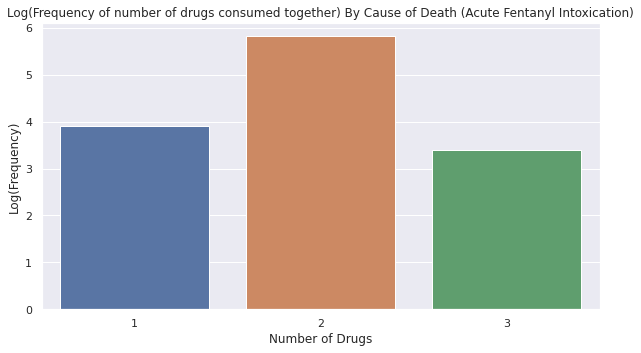

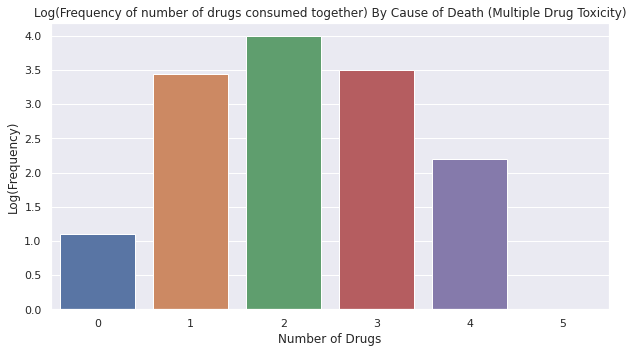

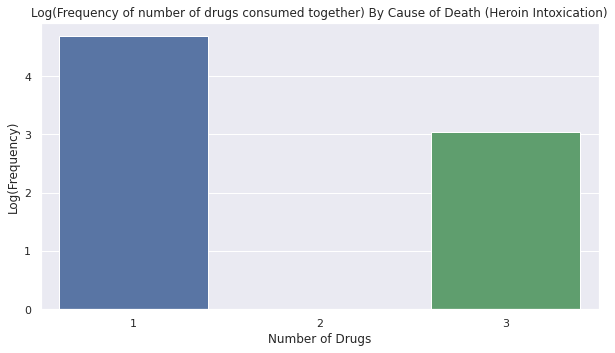

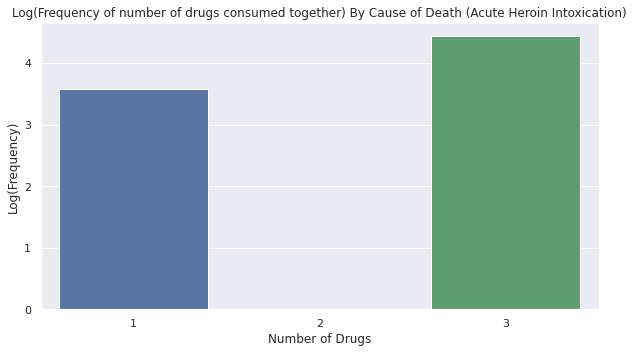

In [32]:
sns.set(rc={'figure.figsize':(1,1.27)})
# Using the function defined above
graph('Cause of Death', tox_copy, df, False, uniq, True)

In [33]:
tox_copy['Cause of Death'].value_counts()

Acute Fentanyl Intoxication    416
Multiple Drug Toxicity         131
Heroin Intoxication            130
Acute Heroin Intoxication      121
Name: Cause of Death, dtype: int64

#### `Cause of Death` & `Manner of Death` 

- To begin with we see that the `Manner of Death` for nearly $95\%$ of the data has the category `Accident` hence being the most likely event for drug-related deaths for our data. Therefore, we will be coupling this fact with our other insights as by itself, it doesnt hold that much significance

- `Cause of Death` on the other hand seems to be a classic example of an overaly cateorized data. With only four categories having counts above 100 in a data with $N ≈ 9200$, calls for a truncation of the attirbute, considering a selected few. We choose the top 4, manipulate our dataframes a bit and achieve the above visulisation.

- As for the `Acute Heroin Intoxication (AHI)` and `Heroin Intoxication (HI)`, one can see a wave of similarity between the two. However, there is one interesting point to be noted. Though, one might be able to infer from their names, its imperative that we have seen this empirically through visualisation

- A person suffering from `AHI` is less likely to be part of single substance abuse but rather multiple (also proves the medical defination of AHI). On the other hand, its the opposite for `HI` where the drug most likely consumed is `Heroin` itself. In the context of pattern mining, we infer that $conf(AHI → n) > conf(HI → n).$ 

- Coming to `Multiple Drug Toxicity (MDT)` and `Acute Fentanyl Intoxication (AFI)`, we ar reminded of the *hill-shaped distribution* we saw in the begining. This means we are close to unravelling the explanation. 

- For `MDT` we see that not only it follows the distribution, but also its prominent for greater $n$ even more than `AFI` which we deduced earlier was signifcantly correlated with `n`. This gives rise to two main points. For small $n$, `AFI` seems to play a greater role and for greater $n$ `MDT`. In regards to the notation we have been using until now, $conf(MDT → n) > conf(AFI → n)$ for large $n$.

- Taking into account all information we have gathered till now, we can infer the following about the *hill-shaped distribution*. For small $n$, we saw a rise in the frequency of such cases which follows from the high frequency of `AFI`. However, for larger n, due to signifcantly reduced frequency of `MDT` (nearly 3 times less), we saw a decrease in the number of cases. It's important to note that there is very much a possibility of numerous other factors at play, but for now we are interested in filtering out the relatively important ones. These two seem to control a significant portion of the variation in $n$.


#### **District Level Analysis** & `Cause of Death`

- Instead off blindly just grouping the data by district and observing the frequency of the "Manner of Death" which we have already determined manily to be `Accident`, its essential that we tackle the root of the cause i.e. `Cause of Death`. As per our previous analysis, we will particularly be interested in how this relationship scales with $n$ but this time with partiuclar attention to `AFI & MDT`

- But *why* are we doing such analysis? After we have somewhat narrowed down the key categories, next comes the real question *why these two and not any other?* One way to tackle this can be in looking for any patterns in the ***sourcing*** of these drugs. 

- For example, which of the cities/town in connecticut or in general do we see large amounts of "Fentanyl" consumed/procured and correspondingly we will arrive at the crux of the matter which drug for "small $n$" is responsible for a significants number of deaths (again most probably led to "Accident") and where. Similarly can be said for large $n$. 

- For this we would be making use of the attributes `ResidenceCityGeo`, `DeathCityeo`, `Residence City`, `Death City` . Getting an idea of where such consumption is prominent can be relatively simple, seeing that we have access to the latter attribute. However, things get interesting when we require an insight into the crux of the matter i.e. the supply of such drugs. This is where the former attribute comes in handy. 

- For this analysis, we will be making one **crucial** assumption. 
  - Cities in conneticut though are connected to each other have a decreasing role to play in the consumption of drugs farther away than those closer to it. This is neccessary to isolate/limit the various possibilites of drug consumption/supply we can have instead of getting mixed/confused in the never-ending thought of literally "What if "Rockville" transported its drugs to "Cannan""

- One last crucial point in determining the procurement of drugs is to use the concept of **intersection**. Cities where we see high cases of `MDT & AFI` combined and correspondingly death city is the same for them, then it's more likely that that specific city is responsible for procurement and correspondinly consumption of such substances. 

In [34]:
# Consider the 'Residence City'

-1 in df['Residence City'].unique()
# We dont have any missing values!

False

In [35]:
# We have missing values in death city.
-1 in df['Death City'].unique()

True

In [36]:
# To deal with missing values in 'Death City', we can assign 'Residence City' Values to them instead as such is most likely not to affect and it seems sensible

df['Death City'] = np.where(df['Death City'] == -1, df['Residence City'], df['Death City'])
-1 in df['Death City'].unique()

False

In [37]:
x = df[['Death City', 'Residence City']]
x

Death City Residence City
0        STAMFORD       STAMFORD
1         NORWICH        NORWICH
2     MARLBOROUGH         HEBRON
3          BALTIC         BALTIC
4      BRIDGEPORT        SHELTON
...           ...            ...
9197     STAMFORD       STAMFORD
9198    NEW HAVEN     WEST HAVEN
9199     HARTFORD   WETHERSFIELD
9200     HARTFORD       HARTFORD
9201      SEYMOUR        SEYMOUR

[9202 rows x 2 columns]

In [38]:
# First let's get an overall picture of the top 10 frequency of deaths by city by simply counting 
y = (x['Death City'].value_counts()).head(10)
y

HARTFORD       1083
NEW HAVEN       765
WATERBURY       728
BRIDGEPORT      625
NEW BRITAIN     360
BRISTOL         251
NEW LONDON      246
NORWICH         244
MERIDEN         233
DANBURY         232
Name: Death City, dtype: int64

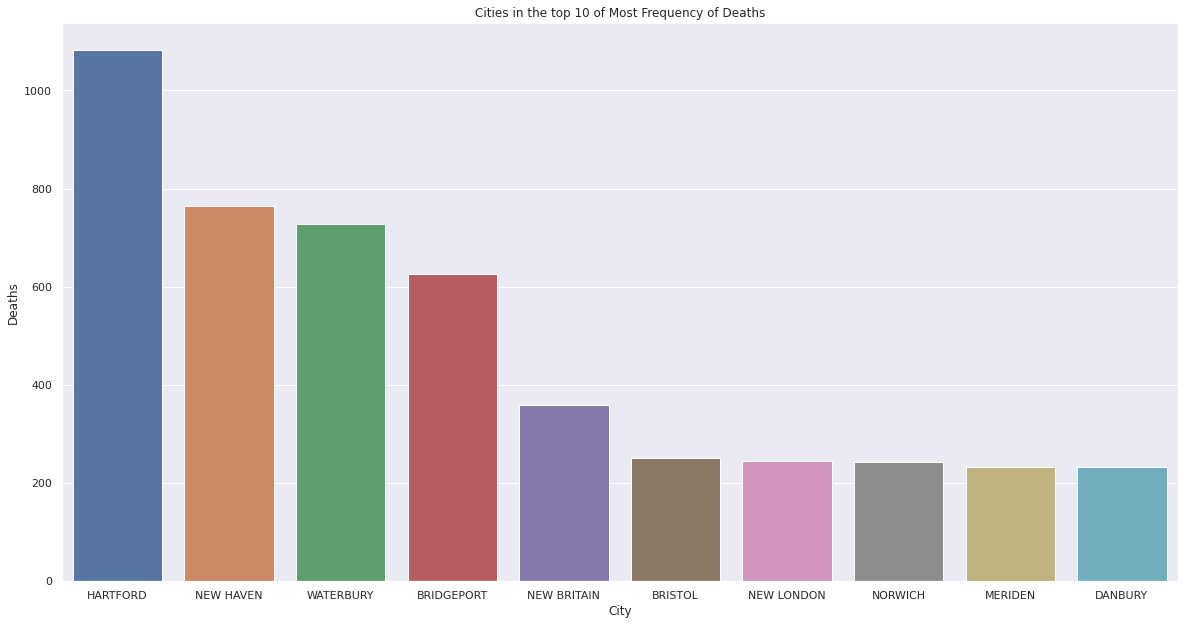

In [39]:
# Let's plot the bar graph
sns.set(rc={'figure.figsize':(20,10.27)})

fig, axes = plt.subplots()

ax1 = sns.barplot(x = y.index, y = (y.values))
ax1.set(title = 'Cities in the top 10 of Most Frequency of Deaths', xlabel = "City", ylabel = "Deaths")
plt.show()

In [40]:
# For now let's only say that Hartford has the most deaths hence its support and confidence for death is likely to be higher than the rest 

In [41]:
#'Let's add residence city to our tox_report. 
tox_report_city = pd.concat([tox_report, df['Residence City']], axis = 1)
# Let's add the cause of death
tox_report_city = pd.concat([tox_report_city, df['Cause of Death']], axis = 1)
# Let's add Death city
tox_report_city = pd.concat([tox_report_city, df['Death City']], axis = 1)


In [42]:
tox_report_city

Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
0          0        1         0                  0          0            0   
1          1        0         0                  0          0            0   
2          1        0         0                  0          0            0   
3          1        0         0                  0          0            0   
4          0        0         1                  0          0            0   
...      ...      ...       ...                ...        ...          ...   
9197       0        1         0                  0          1            0   
9198       0        1         0                  0          0            0   
9199       0        1         0                  0          0            0   
9200       0        1         0                  0          0            0   
9201       0        0         1                  0          0            0   

      Ethanol  Hydrocodone  Benzodiazepine  Methadone  ...  Gabapentin  \
0           0            0               0          0  ...           0   
1           0            0               0          0  ...           0   
2           0            0               0          0  ...           0   
3           0            0               0          0  ...           0   
4           0            0               0          0  ...           0   
...       ...          ...             ...        ...  ...         ...   
9197        0            0               0          0  ...           0   
9198        1            0               0          0  ...           0   
9199        0            0               0          0  ...           1   
9200        0            0               0          0  ...           0   
9201        0            0               0          1  ...           0   

      Opiate NOS  Heroin/Morph/Codeine  Other Opioid  Any Opioid  Other  \
0              0                     0             0           0      0   
1              0                     0             0           0      0   
2              0                     0             0           0      0   
3              0                     0             0           0      0   
4              0                     0             0           1      0   
...          ...                   ...           ...         ...    ...   
9197           0                     0             0           1      0   
9198           0                     0             0           0      0   
9199           0                     0             0           0      0   
9200           0                     0             0           0      0   
9201           0                     0             0           1      0   

      count  Residence City  \
0         1        STAMFORD   
1         1         NORWICH   
2         1          HEBRON   
3         1          BALTIC   
4         2         SHELTON   
...     ...             ...   
9197      3        STAMFORD   
9198      2      WEST HAVEN   
9199      2    WETHERSFIELD   
9200      1        HARTFORD   
9201      4         SEYMOUR   

                                         Cause of Death   Death City  
0                                      Cocaine Toxicity     STAMFORD  
1                                       Heroin Toxicity      NORWICH  
2                                   Heroin Intoxication  MARLBOROUGH  
3                             Acute Heroin Intoxication       BALTIC  
4                           Acute Fentanyl Intoxication   BRIDGEPORT  
...                                                 ...          ...  
9197  Acute Intoxication by the Combined Effects of ...     STAMFORD  
9198  Complications of Acute Substance Intoxication ...    NEW HAVEN  
9199  Acute Intoxication by the Combined Effects of ...     HARTFORD  
9200                         Acute Cocaine Intoxication     HARTFORD  
9201  Acute Intoxication by the Combined Effects of ...      SEYMOUR  

[9202 rows x 26 columns]

In [43]:
# Now we will see how our n variable behave under restrictions imposed earlier i.e. 'Cause of Death == 'MDT' & 'Acute Fentanyl Intoxication'. and Death City == Residence City
tox_report_city = tox_report_city.loc[(tox_report_city['Cause of Death'] == 'Acute Fentanyl Intoxication') | (tox_report_city['Cause of Death'] == 'Multiple Drug Toxicity')]

tox_report_city = tox_report_city.loc[(tox_report_city['Residence City'] == tox_report_city['Death City'])]

# Dropping 'Death City' as no use any more
tox_report_city.drop(['Death City'], axis = 1, inplace = True)

tox_report_city

Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
90         0        0         1                  0          0            0   
116        1        0         0                  0          0            0   
130        0        0         1                  0          0            0   
161        0        0         0                  0          1            1   
221        0        0         1                  0          0            0   
...      ...      ...       ...                ...        ...          ...   
8963       0        0         1                  0          0            0   
8979       0        0         1                  0          0            0   
9006       0        0         1                  0          0            0   
9046       0        0         1                  0          0            0   
9185       0        0         1                  0          0            0   

      Ethanol  Hydrocodone  Benzodiazepine  Methadone  ...  Xylazine  \
90          0            0               0          0  ...         0   
116         0            0               1          0  ...         0   
130         0            0               0          0  ...         0   
161         0            0               1          1  ...         0   
221         0            0               0          0  ...         0   
...       ...          ...             ...        ...  ...       ...   
8963        0            0               0          0  ...         0   
8979        0            0               0          0  ...         0   
9006        0            0               0          0  ...         0   
9046        0            0               0          0  ...         0   
9185        0            0               0          0  ...         0   

      Gabapentin  Opiate NOS  Heroin/Morph/Codeine  Other Opioid  Any Opioid  \
90             0           0                     0             0           1   
116            0           0                     0             0           0   
130            0           0                     0             0           1   
161            0           0                     0             0           0   
221            0           0                     0             0           1   
...          ...         ...                   ...           ...         ...   
8963           0           0                     0             0           1   
8979           0           0                     0             0           1   
9006           0           0                     0             0           1   
9046           0           0                     0             0           1   
9185           0           0                     0             0           1   

      Other  count  Residence City               Cause of Death  
90        0      2       WOODSTOCK  Acute Fentanyl Intoxication  
116       0      2          MONROE       Multiple Drug Toxicity  
130       0      2       NEW HAVEN  Acute Fentanyl Intoxication  
161       0      4       STRATFORD       Multiple Drug Toxicity  
221       0      2      NEW LONDON  Acute Fentanyl Intoxication  
...     ...    ...             ...                          ...  
8963      0      2       WOODSTOCK  Acute Fentanyl Intoxication  
8979      0      2         BRISTOL  Acute Fentanyl Intoxication  
9006      0      2          HAMDEN  Acute Fentanyl Intoxication  
9046      0      2        ROCKFALL  Acute Fentanyl Intoxication  
9185      0      2      MANCHESTER  Acute Fentanyl Intoxication  

[389 rows x 25 columns]

In [44]:
# Now getting the frequency of the cities by state.
grouped_data = tox_report_city.groupby(['Residence City', 'Cause of Death']).sum()

# pivot the table to get City wise instances of each Cause of death along with their counts
pivot_table = pd.pivot_table(grouped_data, values='count', index = 'Residence City', columns='Cause of Death', aggfunc='sum', fill_value = 0)

print(pivot_table)

Cause of Death  Acute Fentanyl Intoxication  Multiple Drug Toxicity
Residence City                                                     
ANSONIA                                   2                       2
BEACON FALLS                              2                       0
BERLIN                                    4                       4
BETHANY                                   2                       0
BETHEL                                    0                       2
...                                     ...                     ...
WILLIMANTIC                               2                       3
WINDHAM                                   2                       0
WINDSOR                                   6                       0
WINDSOR LOCKS                             7                       2
WOODSTOCK                                 6                       0

[94 rows x 2 columns]


In [45]:
# We cant see any useful information like this and visualising it through bar graph like before is not feasible as we have over 90 categories. Therefore let's resort geo-spatial visualization and make use of the following dataframe

In [46]:
part4

ResidenceCityGeo  \
0         STAMFORD, CT\n(41.051924, -73.539475)   
1          NORWICH, CT\n(41.524304, -72.075821)   
2           HEBRON, CT\n(41.658069, -72.366324)   
3           BALTIC, CT\n(41.617221, -72.085031)   
4          SHELTON, CT\n(41.316843, -73.092968)   
...                                         ...   
9197      STAMFORD, CT\n(41.051924, -73.539475)   
9198    WEST HAVEN, CT\n(41.272336, -72.949817)   
9199  WETHERSFIELD, CT\n(41.712487, -72.663607)   
9200      HARTFORD, CT\n(41.765775, -72.673356)   
9201       SEYMOUR, CT\n(41.395594, -73.073581)   

                                  InjuryCityGeo  \
0         STAMFORD, CT\n(41.051924, -73.539475)   
1          NORWICH, CT\n(41.524304, -72.075821)   
2           HEBRON, CT\n(41.658069, -72.366324)   
3                   CT\n(41.575155, -72.738288)   
4          SHELTON, CT\n(41.316843, -73.092968)   
...                                         ...   
9197      STAMFORD, CT\n(41.051924, -73.539475)   
9198    WEST HAVEN, CT\n(41.272336, -72.949817)   
9199  WETHERSFIELD, CT\n(41.712487, -72.663607)   
9200      HARTFORD, CT\n(41.765775, -72.673356)   
9201       SEYMOUR, CT\n(41.395594, -73.073581)   

                                  DeathCityGeo  
0                  CT\n(41.575155, -72.738288)  
1         Norwich, CT\n(41.524304, -72.075821)  
2     Marlborough, CT\n(41.632043, -72.461309)  
3          Baltic, CT\n(41.617221, -72.085031)  
4      Bridgeport, CT\n(41.179195, -73.189476)  
...                                        ...  
9197     Stamford, CT\n(41.051924, -73.539475)  
9198    New Haven, CT\n(41.308252, -72.924161)  
9199     Hartford, CT\n(41.765775, -72.673356)  
9200     Hartford, CT\n(41.765775, -72.673356)  
9201      Seymour, CT\n(41.395594, -73.073581)  

[9202 rows x 3 columns]

In [47]:
# Making a function which when given string in the format seen above in the dataframe, returns the city and its location coardinates using regular expressions
def seperate(row):
  # Getting the row string
  state_match = re.findall(r'[A-Za-z ]+, [A-Z]{2}', row)
  # If there exists no state in the column then we randomly assign it from its categories
  state = state_match[0].split(', ')[0] if state_match else np.random.choice(df['Residence City'].unique())
  # Getting the latitude and longitude
  numbers = re.findall(r'\(([\d.-]+), ([\d.-]+)\)', row)[0]
  lattitude = float(numbers[0])
  longitude = float(numbers[1])
  
  return (state, lattitude, longitude)

In [49]:
# For our simple analysis we will see if we can drop the missing values
df['ResidenceCityGeo'].value_counts()[-1] # 165: Assumed Negligible compared to 9200
df['InjuryCityGeo'].value_counts()[-1] # 211: Assumed Negligible compared to 9200
df['DeathCityGeo'].value_counts()[-1] # 1: Assumed Negligible compared to 9200

# Dropping all rows with -1
part4 = part4.fillna(-1)
part4 = part4.drop(part4[part4 == -1].dropna(how = 'all').index)

part4

ResidenceCityGeo  \
0         STAMFORD, CT\n(41.051924, -73.539475)   
1          NORWICH, CT\n(41.524304, -72.075821)   
2           HEBRON, CT\n(41.658069, -72.366324)   
3           BALTIC, CT\n(41.617221, -72.085031)   
4          SHELTON, CT\n(41.316843, -73.092968)   
...                                         ...   
9197      STAMFORD, CT\n(41.051924, -73.539475)   
9198    WEST HAVEN, CT\n(41.272336, -72.949817)   
9199  WETHERSFIELD, CT\n(41.712487, -72.663607)   
9200      HARTFORD, CT\n(41.765775, -72.673356)   
9201       SEYMOUR, CT\n(41.395594, -73.073581)   

                                  InjuryCityGeo  \
0         STAMFORD, CT\n(41.051924, -73.539475)   
1          NORWICH, CT\n(41.524304, -72.075821)   
2           HEBRON, CT\n(41.658069, -72.366324)   
3                   CT\n(41.575155, -72.738288)   
4          SHELTON, CT\n(41.316843, -73.092968)   
...                                         ...   
9197      STAMFORD, CT\n(41.051924, -73.539475)   
9198    WEST HAVEN, CT\n(41.272336, -72.949817)   
9199  WETHERSFIELD, CT\n(41.712487, -72.663607)   
9200      HARTFORD, CT\n(41.765775, -72.673356)   
9201       SEYMOUR, CT\n(41.395594, -73.073581)   

                                  DeathCityGeo  
0                  CT\n(41.575155, -72.738288)  
1         Norwich, CT\n(41.524304, -72.075821)  
2     Marlborough, CT\n(41.632043, -72.461309)  
3          Baltic, CT\n(41.617221, -72.085031)  
4      Bridgeport, CT\n(41.179195, -73.189476)  
...                                        ...  
9197     Stamford, CT\n(41.051924, -73.539475)  
9198    New Haven, CT\n(41.308252, -72.924161)  
9199     Hartford, CT\n(41.765775, -72.673356)  
9200     Hartford, CT\n(41.765775, -72.673356)  
9201      Seymour, CT\n(41.395594, -73.073581)  

[8838 rows x 3 columns]

In [50]:
# Sorting the index
part4.reset_index(drop = True, inplace = True)
part4

ResidenceCityGeo  \
0         STAMFORD, CT\n(41.051924, -73.539475)   
1          NORWICH, CT\n(41.524304, -72.075821)   
2           HEBRON, CT\n(41.658069, -72.366324)   
3           BALTIC, CT\n(41.617221, -72.085031)   
4          SHELTON, CT\n(41.316843, -73.092968)   
...                                         ...   
8833      STAMFORD, CT\n(41.051924, -73.539475)   
8834    WEST HAVEN, CT\n(41.272336, -72.949817)   
8835  WETHERSFIELD, CT\n(41.712487, -72.663607)   
8836      HARTFORD, CT\n(41.765775, -72.673356)   
8837       SEYMOUR, CT\n(41.395594, -73.073581)   

                                  InjuryCityGeo  \
0         STAMFORD, CT\n(41.051924, -73.539475)   
1          NORWICH, CT\n(41.524304, -72.075821)   
2           HEBRON, CT\n(41.658069, -72.366324)   
3                   CT\n(41.575155, -72.738288)   
4          SHELTON, CT\n(41.316843, -73.092968)   
...                                         ...   
8833      STAMFORD, CT\n(41.051924, -73.539475)   
8834    WEST HAVEN, CT\n(41.272336, -72.949817)   
8835  WETHERSFIELD, CT\n(41.712487, -72.663607)   
8836      HARTFORD, CT\n(41.765775, -72.673356)   
8837       SEYMOUR, CT\n(41.395594, -73.073581)   

                                  DeathCityGeo  
0                  CT\n(41.575155, -72.738288)  
1         Norwich, CT\n(41.524304, -72.075821)  
2     Marlborough, CT\n(41.632043, -72.461309)  
3          Baltic, CT\n(41.617221, -72.085031)  
4      Bridgeport, CT\n(41.179195, -73.189476)  
...                                        ...  
8833     Stamford, CT\n(41.051924, -73.539475)  
8834    New Haven, CT\n(41.308252, -72.924161)  
8835     Hartford, CT\n(41.765775, -72.673356)  
8836     Hartford, CT\n(41.765775, -72.673356)  
8837      Seymour, CT\n(41.395594, -73.073581)  

[8838 rows x 3 columns]

In [51]:
# Now making another function which will return a separte dataframe sepearted based on the function defined above
def getGeo(col):
  df = pd.DataFrame(np.zeros((len(part4), 3)), columns = ['State', 'Latitude', 'Longitude'])
  df['State'] = part4[col].apply(lambda text: seperate(text)[0])
  df['Latitude'] = part4[col].apply(lambda text: seperate(text)[1])
  df['Longitude'] = part4[col].apply(lambda text: seperate(text)[2])
  return df

In [52]:
first = getGeo('ResidenceCityGeo')
first.reset_index(inplace = True, drop = True)
first ## Has each residence city along with its coardinates

State   Latitude  Longitude
0         STAMFORD  41.051924 -73.539475
1          NORWICH  41.524304 -72.075821
2           HEBRON  41.658069 -72.366324
3           BALTIC  41.617221 -72.085031
4          SHELTON  41.316843 -73.092968
...            ...        ...        ...
8833      STAMFORD  41.051924 -73.539475
8834    WEST HAVEN  41.272336 -72.949817
8835  WETHERSFIELD  41.712487 -72.663607
8836      HARTFORD  41.765775 -72.673356
8837       SEYMOUR  41.395594 -73.073581

[8838 rows x 3 columns]

In [53]:
# Making a function which when given a state and corresponding df, returns its latitude and longitude

def get_coardinates(state, df):
  lat = df[(df['State'] == state)]['Latitude'].iloc[0]
  lon = df[(df['State'] == state)]['Longitude'].iloc[0]

  return(lat, lon)

In [54]:
# Sorting index and looking at it.
tox_report_city.reset_index(drop = True, inplace = True)
tox_report_city

Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
0         0        0         1                  0          0            0   
1         1        0         0                  0          0            0   
2         0        0         1                  0          0            0   
3         0        0         0                  0          1            1   
4         0        0         1                  0          0            0   
..      ...      ...       ...                ...        ...          ...   
384       0        0         1                  0          0            0   
385       0        0         1                  0          0            0   
386       0        0         1                  0          0            0   
387       0        0         1                  0          0            0   
388       0        0         1                  0          0            0   

     Ethanol  Hydrocodone  Benzodiazepine  Methadone  ...  Xylazine  \
0          0            0               0          0  ...         0   
1          0            0               1          0  ...         0   
2          0            0               0          0  ...         0   
3          0            0               1          1  ...         0   
4          0            0               0          0  ...         0   
..       ...          ...             ...        ...  ...       ...   
384        0            0               0          0  ...         0   
385        0            0               0          0  ...         0   
386        0            0               0          0  ...         0   
387        0            0               0          0  ...         0   
388        0            0               0          0  ...         0   

     Gabapentin  Opiate NOS  Heroin/Morph/Codeine  Other Opioid  Any Opioid  \
0             0           0                     0             0           1   
1             0           0                     0             0           0   
2             0           0                     0             0           1   
3             0           0                     0             0           0   
4             0           0                     0             0           1   
..          ...         ...                   ...           ...         ...   
384           0           0                     0             0           1   
385           0           0                     0             0           1   
386           0           0                     0             0           1   
387           0           0                     0             0           1   
388           0           0                     0             0           1   

     Other  count  Residence City               Cause of Death  
0        0      2       WOODSTOCK  Acute Fentanyl Intoxication  
1        0      2          MONROE       Multiple Drug Toxicity  
2        0      2       NEW HAVEN  Acute Fentanyl Intoxication  
3        0      4       STRATFORD       Multiple Drug Toxicity  
4        0      2      NEW LONDON  Acute Fentanyl Intoxication  
..     ...    ...             ...                          ...  
384      0      2       WOODSTOCK  Acute Fentanyl Intoxication  
385      0      2         BRISTOL  Acute Fentanyl Intoxication  
386      0      2          HAMDEN  Acute Fentanyl Intoxication  
387      0      2        ROCKFALL  Acute Fentanyl Intoxication  
388      0      2      MANCHESTER  Acute Fentanyl Intoxication  

[389 rows x 25 columns]

In [55]:
# Now let's add the coardinates to our tox_report_city but before that let's remove cities for which we dont have any latitudes or longitudes

for idx, city in enumerate(tox_report_city['Residence City']):
  if city not in first['State'].unique():
    tox_report_city = tox_report_city.drop(tox_report_city[tox_report_city['Residence City'] == city].index)
tox_report_city

Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
0         0        0         1                  0          0            0   
1         1        0         0                  0          0            0   
2         0        0         1                  0          0            0   
3         0        0         0                  0          1            1   
4         0        0         1                  0          0            0   
..      ...      ...       ...                ...        ...          ...   
384       0        0         1                  0          0            0   
385       0        0         1                  0          0            0   
386       0        0         1                  0          0            0   
387       0        0         1                  0          0            0   
388       0        0         1                  0          0            0   

     Ethanol  Hydrocodone  Benzodiazepine  Methadone  ...  Xylazine  \
0          0            0               0          0  ...         0   
1          0            0               1          0  ...         0   
2          0            0               0          0  ...         0   
3          0            0               1          1  ...         0   
4          0            0               0          0  ...         0   
..       ...          ...             ...        ...  ...       ...   
384        0            0               0          0  ...         0   
385        0            0               0          0  ...         0   
386        0            0               0          0  ...         0   
387        0            0               0          0  ...         0   
388        0            0               0          0  ...         0   

     Gabapentin  Opiate NOS  Heroin/Morph/Codeine  Other Opioid  Any Opioid  \
0             0           0                     0             0           1   
1             0           0                     0             0           0   
2             0           0                     0             0           1   
3             0           0                     0             0           0   
4             0           0                     0             0           1   
..          ...         ...                   ...           ...         ...   
384           0           0                     0             0           1   
385           0           0                     0             0           1   
386           0           0                     0             0           1   
387           0           0                     0             0           1   
388           0           0                     0             0           1   

     Other  count  Residence City               Cause of Death  
0        0      2       WOODSTOCK  Acute Fentanyl Intoxication  
1        0      2          MONROE       Multiple Drug Toxicity  
2        0      2       NEW HAVEN  Acute Fentanyl Intoxication  
3        0      4       STRATFORD       Multiple Drug Toxicity  
4        0      2      NEW LONDON  Acute Fentanyl Intoxication  
..     ...    ...             ...                          ...  
384      0      2       WOODSTOCK  Acute Fentanyl Intoxication  
385      0      2         BRISTOL  Acute Fentanyl Intoxication  
386      0      2          HAMDEN  Acute Fentanyl Intoxication  
387      0      2        ROCKFALL  Acute Fentanyl Intoxication  
388      0      2      MANCHESTER  Acute Fentanyl Intoxication  

[389 rows x 25 columns]

In [56]:
# Now let's add the latitudes and longitudes
tox_report_city['Latitude'] = tox_report_city['Residence City'].apply(lambda state: get_coardinates(state, first)[0])
tox_report_city['Longitude'] = tox_report_city['Residence City'].apply(lambda state: get_coardinates(state, first)[1])
tox_report_city

Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
0         0        0         1                  0          0            0   
1         1        0         0                  0          0            0   
2         0        0         1                  0          0            0   
3         0        0         0                  0          1            1   
4         0        0         1                  0          0            0   
..      ...      ...       ...                ...        ...          ...   
384       0        0         1                  0          0            0   
385       0        0         1                  0          0            0   
386       0        0         1                  0          0            0   
387       0        0         1                  0          0            0   
388       0        0         1                  0          0            0   

     Ethanol  Hydrocodone  Benzodiazepine  Methadone  ...  Opiate NOS  \
0          0            0               0          0  ...           0   
1          0            0               1          0  ...           0   
2          0            0               0          0  ...           0   
3          0            0               1          1  ...           0   
4          0            0               0          0  ...           0   
..       ...          ...             ...        ...  ...         ...   
384        0            0               0          0  ...           0   
385        0            0               0          0  ...           0   
386        0            0               0          0  ...           0   
387        0            0               0          0  ...           0   
388        0            0               0          0  ...           0   

     Heroin/Morph/Codeine  Other Opioid  Any Opioid  Other  count  \
0                       0             0           1      0      2   
1                       0             0           0      0      2   
2                       0             0           1      0      2   
3                       0             0           0      0      4   
4                       0             0           1      0      2   
..                    ...           ...         ...    ...    ...   
384                     0             0           1      0      2   
385                     0             0           1      0      2   
386                     0             0           1      0      2   
387                     0             0           1      0      2   
388                     0             0           1      0      2   

     Residence City               Cause of Death   Latitude  Longitude  
0         WOODSTOCK  Acute Fentanyl Intoxication  41.950652 -71.977285  
1            MONROE       Multiple Drug Toxicity  41.331612 -73.206797  
2         NEW HAVEN  Acute Fentanyl Intoxication  41.308252 -72.924161  
3         STRATFORD       Multiple Drug Toxicity  41.200888 -73.131323  
4        NEW LONDON  Acute Fentanyl Intoxication  41.355167 -72.099561  
..              ...                          ...        ...        ...  
384       WOODSTOCK  Acute Fentanyl Intoxication  41.950652 -71.977285  
385         BRISTOL  Acute Fentanyl Intoxication  41.673037 -72.945791  
386          HAMDEN  Acute Fentanyl Intoxication  41.382918 -72.907743  
387        ROCKFALL  Acute Fentanyl Intoxication  41.530602 -72.695000  
388      MANCHESTER  Acute Fentanyl Intoxication  41.770668 -72.520868  

[389 rows x 27 columns]

In [57]:
# Making a function which given one of the residence data returns state wise count of each of the instances of MDT and AFI along with its geographical coardinates

def grouped(df):
  grouped = df.groupby(['Residence City', 'Cause of Death']).agg({'Cause of Death': 'count'})

  # # rename the 'Cause of Death' column to 'Count' for better inspection
  grouped = grouped.rename(columns = {'Cause of Death': 'Count'})

  # # pivot the table to get 'MDT' and 'AFI' as separate columns and fill na values as 0
  grouped = grouped.pivot_table(values = 'Count', index = 'Residence City', columns = ['Cause of Death'], fill_value = 0)

  # # rename the columns
  grouped.columns = ['MDT', 'AFI']

  # reset the index to make 'Residence City' a separate column
  grouped = grouped.reset_index()

  # Adding latitude and longitude
  grouped['Latitude'] = grouped['Residence City'].apply(lambda state: (get_coardinates(state, first))[0])
  grouped['Longitude'] = grouped['Residence City'].apply(lambda state: (get_coardinates(state, first))[1])

  return grouped

In [58]:
res_group = grouped(tox_report_city)
res_group

Residence City  MDT  AFI   Latitude  Longitude
0         ANSONIA    1    1  41.341980 -73.078296
1    BEACON FALLS    1    0  41.444336 -73.060658
2          BERLIN    2    1  41.626049 -72.749301
3         BETHANY    1    0  41.575155 -72.738288
4          BETHEL    0    1  41.371727 -73.407448
..            ...  ...  ...        ...        ...
89    WILLIMANTIC    1    1  41.711724 -72.211975
90        WINDHAM    1    0  41.699744 -72.157703
91        WINDSOR    3    0  41.852781 -72.643790
92  WINDSOR LOCKS    4    1  41.924953 -72.627177
93      WOODSTOCK    3    0  41.950652 -71.977285

[94 rows x 5 columns]

In [59]:
# Using folium, geopandas, colormap and clusterMarker

# create a color map for the MDT/AFI values so that we see different numbers in a different scale
colormap_MDT = linear.YlOrRd_09.scale(
    res_group['MDT'].min(),
    res_group['MDT'].max())
# Create a colormap for AFI values
colormap_AFI = linear.YlOrRd_09.scale(
    res_group['AFI'].min(),
    res_group['AFI'].max())

# create the map centered at conneticut
ctmap = folium.Map(location=[41.6, -72.7], zoom_start=9)

# create a marker cluster layer
marker_cluster = MarkerCluster().add_to(ctmap)

# add the markers at the lat, lon coardinates given by res_group and the MDT/AFT counts
for lat, lon, city, num1, num2 in zip(res_group["Latitude"], res_group["Longitude"], res_group["Residence City"], res_group["MDT"], res_group["AFI"]):
  # Filtering those that are less impactful
  if num1 + num2 >= 2:
    tooltip = f"{city}: MDT = {num1}, AFI = {num2}"
    marker_color = colormap_MDT(num1)
    folium.Marker(
        location = [lat, lon],
        icon = folium.Icon(color = marker_color),
        tooltip = tooltip
    ).add_to(marker_cluster)

# add the choropleth layer for MDT
folium.Choropleth(
    geo_data='/content/drive/MyDrive/CS 432 - Data Mining/Project/ct.geojson', # path to a geojson file with the geometries of the areas in conneticut to shade
    name = 'choropleth',
    data = res_group,
    columns = ['Residence City', 'MDT'], # Those that we will plot first
    key_on='feature.properties.town', # key to match the geojson data with the data frame
    fill_color = 'YlOrRd', # use the same color map as the markers
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'MDT',
    highlight = True, 
    overlay = True 
).add_to(ctmap)

# add the color bar legend for the choropleth layer for MDT
colormap_MDT.caption = 'MDT'

# Similarly add the choropleth layer for AFI
folium.Choropleth(
    geo_data='/content/drive/MyDrive/CS 432 - Data Mining/Project/ct.geojson', 
    name='choropleth',
    data=res_group,
    columns=['Residence City', 'AFI'],
    key_on='feature.properties.town',
    fill_color='YlOrRd', 
    fill_opacity=0.02,
    line_opacity=0.04,
    legend_name='AFI',
    highlight=True, 
    overlay=True 
).add_to(ctmap)

# add the color bar legend for the choropleth layer for AFI
colormap_AFI.caption = 'AFI'
ctmap

#### Geo-Spatial Analysis of `Cause of Death`

- After determining that we had to do a district-wise analysis of the cause of death, it quickly became clear that unlike normal visualisation using bar-graphs, it was infeasible in this case due to the presence of many cities

- After grouping the data `tox_goup_city` by 'Cause of Death' and adding the restriction of `Residence City == Death City` to extract additional features such as procurement of substances from the data, we used the geo-coardinates given to plot the above map.

- A quick glance will reveal that the main source of action of procurment/consumption of such substances (eventually leading to accidents) is happening right in the centre of the Connecticut. 

- With 11 close by neighbours, and edges ranging from *Hartford* to *Meriden* to Bristol it ammasess the most cases of `MDT` and `AFI` combined. More interestingly, if we recall our top 10 cities with the most deaths, many of the cities there can be seen in the cluster $A$ thereby giving strong confidence to our hypothesis and insights. Though there are several other clusters, as well as indiviual clusters, we observe that their cases of `MDT` and `AFI` are more likely to be less than that belonging to the cluster right in the centre.

- If we denote the cluster right in the centre as $A$ and the rest as some $a_{i}$ where $i ∈ \{1, 2, 3, ⋯, M\}$ where $M$ denotes the number of ***intrinsic*** clusters, then it may be likely that $conf(A → \{MDT⇑, AFI ⇑ \})$i.e., if the city is in cluster $A$ then its likely it has a high instances of deaths from `MDT` and `AFI`

- By intrinsic, we mean how the data is supposedly clustered based on off some similar/dissimilar measure. Hence, going forward, we might be interested in forming clusters of states based on `Cause of Death` similarity measure. Its well likely that we may not get the exact result as we have made a crucial assumption as well as ignored other factors from 'Cause of Death'. However, nontheless, it has given us a key insight and facilitated future analysis.


#### Time Series Analysis 

- So far, we have been doing analysis without paying any attention to time. However, doing so can give us additional insights into the trajectory/history of the current states/insights we make.

- For this we will be using the date column provided to us. Along with the useful library of `datetime` from python, we will extract analysis by years with key attributes we have gathered so far. We will be most importantly concerned with `Cause of Death` (Typically `AFI` & `MDT`), and how `year` varies with $n$.

***Note:*** For now, we have decided not to use months as the time series analysis but rather year. For the former, there are likely to be more categories and hence its analysis group-wise may not lead substantial benefits. Whereas, year seems to be simpler doing analysis group wise but at the same time, we have an easier time seeing the trajectory of any key variables. For month, aside from the general trend of increased drug consumption one might see, there may well be ups-downs which we don't have any specific grounds to explain.

In [60]:
# Let's recall part 1 which has the date column
part1.head()

Date      Date Type   Age     Sex   Race Ethnicity Residence City  \
0  05/29/2012  Date of death  37.0    Male  Black       NaN       STAMFORD   
1  06/27/2012  Date of death  37.0    Male  White       NaN        NORWICH   
2  03/24/2014  Date of death  28.0    Male  White       NaN         HEBRON   
3  12/31/2014  Date of death  26.0  Female  White       NaN         BALTIC   
4  01/16/2016  Date of death  41.0    Male  White       NaN        SHELTON   

  Residence County Residence State  
0        FAIRFIELD             NaN  
1       NEW LONDON             NaN  
2              NaN             NaN  
3              NaN             NaN  
4        FAIRFIELD              CT

In [61]:
# Similar to as we did with cities and their coardinates, we will sepearte date, month and year
part1['Date'] = pd.to_datetime(part1['Date'], format='%m/%d/%Y')

# create new columns for date, month, and year
part1['day'] = part1['Date'].dt.day
part1['month'] = part1['Date'].dt.month
part1['year'] = part1['Date'].dt.year
part1

Date      Date Type   Age     Sex                       Race  \
0    2012-05-29  Date of death  37.0    Male                      Black   
1    2012-06-27  Date of death  37.0    Male                      White   
2    2014-03-24  Date of death  28.0    Male                      White   
3    2014-12-31  Date of death  26.0  Female                      White   
4    2016-01-16  Date of death  41.0    Male                      White   
...         ...            ...   ...     ...                        ...   
9197 2021-10-19  Date of death  56.0    Male  Black or African American   
9198 2021-05-04  Date of death  48.0    Male  Black or African American   
9199 2021-05-15  Date of death  59.0    Male                      White   
9200 2021-05-28  Date of death  68.0    Male  Black or African American   
9201 2021-12-24  Date of death  29.0    Male                      White   

                        Ethnicity Residence City Residence County  \
0                             NaN       STAMFORD        FAIRFIELD   
1                             NaN        NORWICH       NEW LONDON   
2                             NaN         HEBRON              NaN   
3                             NaN         BALTIC              NaN   
4                             NaN        SHELTON        FAIRFIELD   
...                           ...            ...              ...   
9197                          NaN       STAMFORD        FAIRFIELD   
9198                          NaN     WEST HAVEN        NEW HAVEN   
9199                          NaN   WETHERSFIELD         HARTFORD   
9200                          NaN       HARTFORD         HARTFORD   
9201  Not Spanish/Hispanic/Latino        SEYMOUR        NEW HAVEN   

     Residence State  day  month  year  
0                NaN   29      5  2012  
1                NaN   27      6  2012  
2                NaN   24      3  2014  
3                NaN   31     12  2014  
4                 CT   16      1  2016  
...              ...  ...    ...   ...  
9197              CT   19     10  2021  
9198              CT    4      5  2021  
9199              CT   15      5  2021  
9200              CT   28      5  2021  
9201              CT   24     12  2021  

[9202 rows x 12 columns]

In [62]:
# For warming up let's get the number of deaths by year by grouping 'Cause of Death' 

-1 in df['Cause of Death'].unique()
# No missing values!

# Let's add it to our part1
part1['Cause of Death'] = df['Cause of Death']
part1.head()

Date      Date Type   Age     Sex   Race Ethnicity Residence City  \
0 2012-05-29  Date of death  37.0    Male  Black       NaN       STAMFORD   
1 2012-06-27  Date of death  37.0    Male  White       NaN        NORWICH   
2 2014-03-24  Date of death  28.0    Male  White       NaN         HEBRON   
3 2014-12-31  Date of death  26.0  Female  White       NaN         BALTIC   
4 2016-01-16  Date of death  41.0    Male  White       NaN        SHELTON   

  Residence County Residence State  day  month  year  \
0        FAIRFIELD             NaN   29      5  2012   
1       NEW LONDON             NaN   27      6  2012   
2              NaN             NaN   24      3  2014   
3              NaN             NaN   31     12  2014   
4        FAIRFIELD              CT   16      1  2016   

                Cause of Death  
0             Cocaine Toxicity  
1              Heroin Toxicity  
2          Heroin Intoxication  
3    Acute Heroin Intoxication  
4  Acute Fentanyl Intoxication

In [63]:
# Now group by year
time_group1 = part1.groupby(['year']).agg({'Cause of Death': 'count'})
time_group1.columns = ['Total Deaths']
time_group1

Total Deaths
year              
2012           355
2013           490
2014           558
2015           729
2016           917
2017          1038
2018          1017
2019          1200
2020          1374
2021          1524

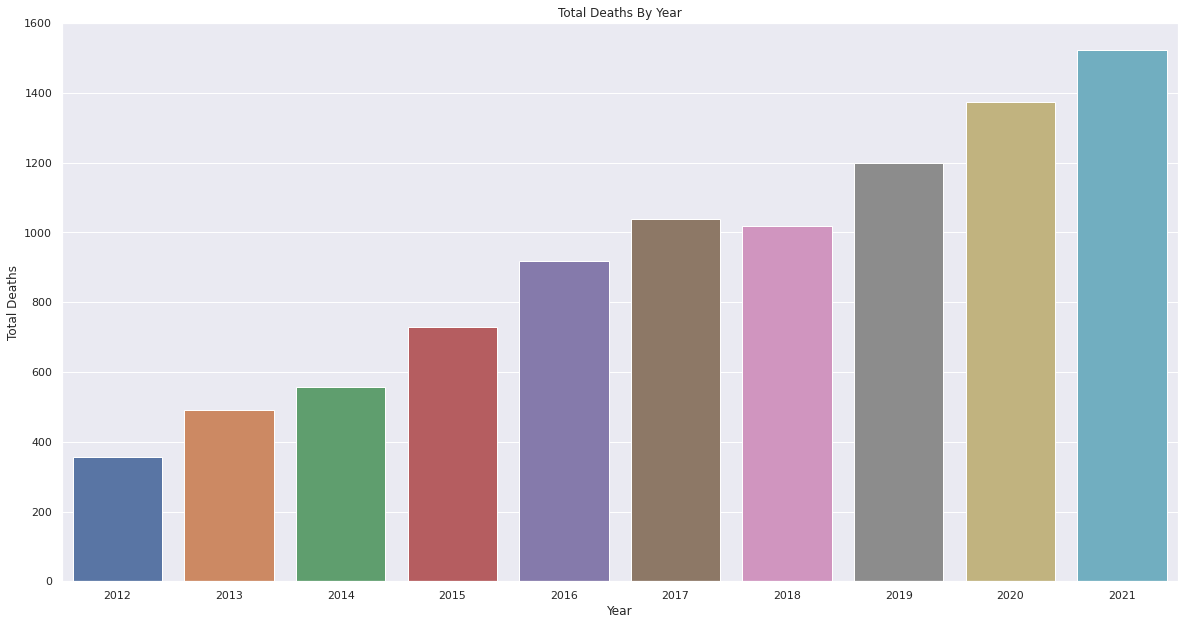

In [64]:
sns.set(rc={'figure.figsize':(20,10.27)})

fig, axes = plt.subplots()

ax1 = sns.barplot(x = list(time_group1.index), y = (time_group1['Total Deaths']))
ax1.set(title = 'Total Deaths By Year', xlabel = "Year", ylabel = "Total Deaths")
plt.show()

In [69]:
# Quickly note that the number of deaths are increasing as time passes by. This suggests that the confidence of year given the number of deaths i.e. the probability of a later time being conisdered
# given number of deaths increases as the deaths increase and vice versa. Now as we have been doing before lets check how the year behaves with n. For that let's add the variable count. For that we will be making use of the 
# tox_report dataframe which contains the complete toxicity report and n.

tox_report_year = pd.concat([tox_report, part1['year']], axis = 1)
tox_report_year

Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
0          0        1         0                  0          0            0   
1          1        0         0                  0          0            0   
2          1        0         0                  0          0            0   
3          1        0         0                  0          0            0   
4          0        0         1                  0          0            0   
...      ...      ...       ...                ...        ...          ...   
9197       0        1         0                  0          1            0   
9198       0        1         0                  0          0            0   
9199       0        1         0                  0          0            0   
9200       0        1         0                  0          0            0   
9201       0        0         1                  0          0            0   

      Ethanol  Hydrocodone  Benzodiazepine  Methadone  ...  \
0           0            0               0          0  ...   
1           0            0               0          0  ...   
2           0            0               0          0  ...   
3           0            0               0          0  ...   
4           0            0               0          0  ...   
...       ...          ...             ...        ...  ...   
9197        0            0               0          0  ...   
9198        1            0               0          0  ...   
9199        0            0               0          0  ...   
9200        0            0               0          0  ...   
9201        0            0               0          1  ...   

      Morphine (Not Heroin)  Xylazine  Gabapentin  Opiate NOS  \
0                         0         0           0           0   
1                         0         0           0           0   
2                         0         0           0           0   
3                         0         0           0           0   
4                         0         0           0           0   
...                     ...       ...         ...         ...   
9197                      0         0           0           0   
9198                      0         0           0           0   
9199                      0         0           1           0   
9200                      0         0           0           0   
9201                      0         1           0           0   

      Heroin/Morph/Codeine  Other Opioid  Any Opioid  Other  count  year  
0                        0             0           0      0      1  2012  
1                        0             0           0      0      1  2012  
2                        0             0           0      0      1  2014  
3                        0             0           0      0      1  2014  
4                        0             0           1      0      2  2016  
...                    ...           ...         ...    ...    ...   ...  
9197                     0             0           1      0      3  2021  
9198                     0             0           0      0      2  2021  
9199                     0             0           0      0      2  2021  
9200                     0             0           0      0      1  2021  
9201                     0             0           1      0      4  2021  

[9202 rows x 24 columns]

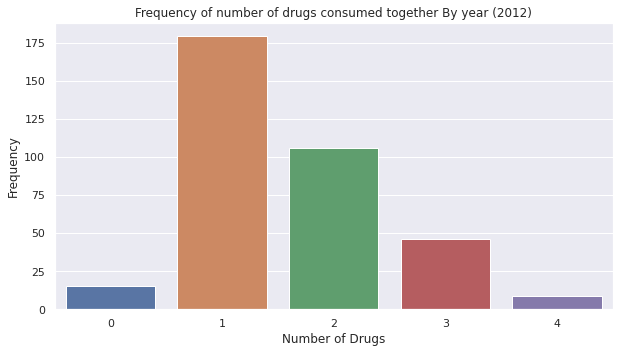

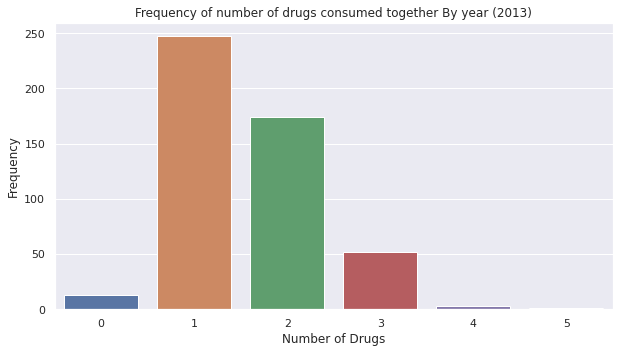

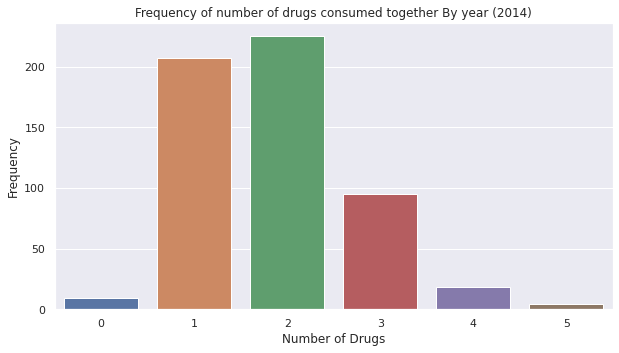

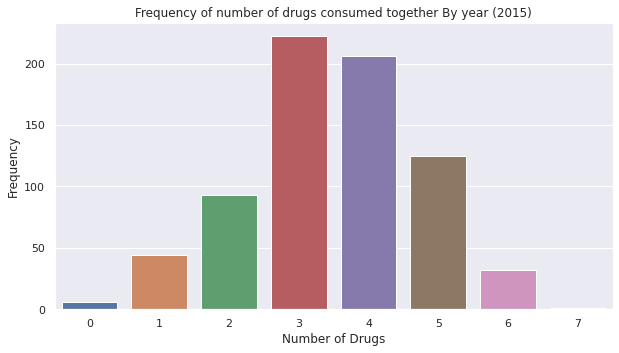

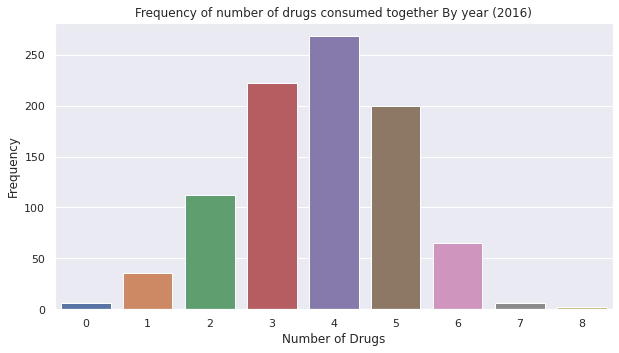

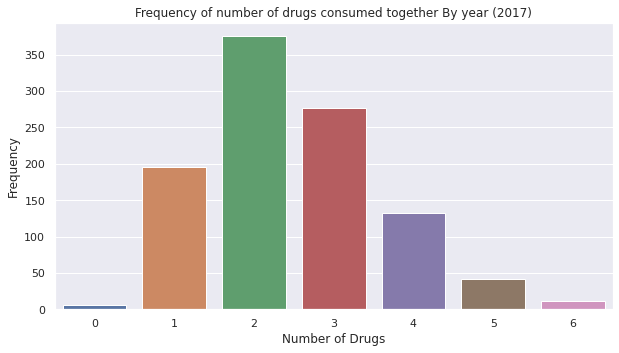

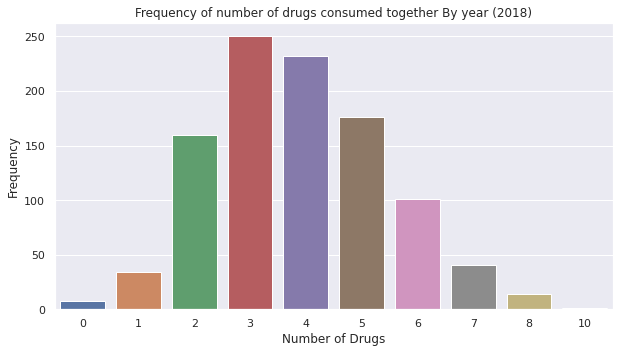

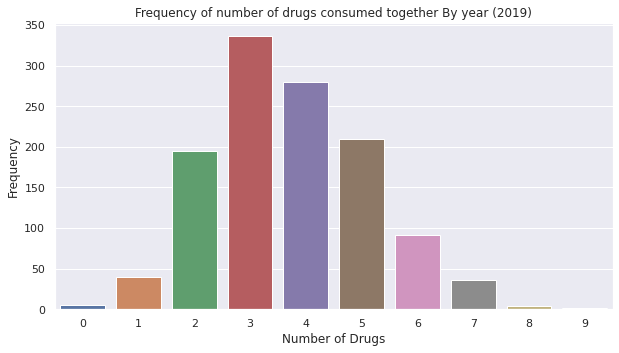

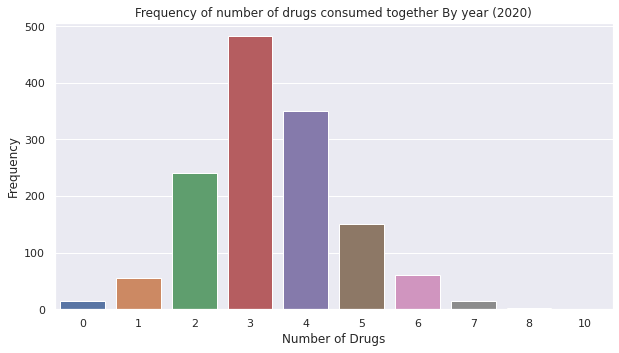

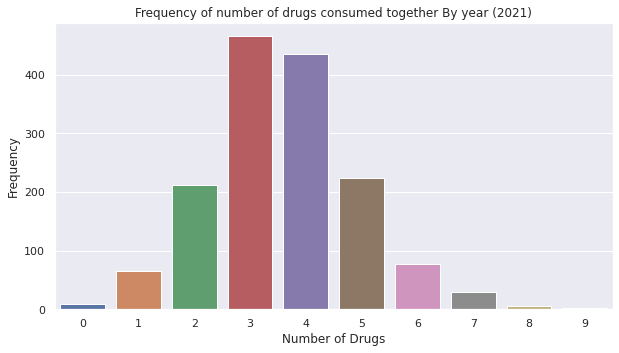

In [70]:
# Let's visualise using a bar plot and our function defined in the begining
graph('year', tox_report_year, df, False, list(time_group1.index), False)

In [75]:
# To analyse this let's try to get one more piece of information.

tox_report_year = pd.concat([tox_report_year, df['Cause of Death']], axis = 1)
cause_year = tox_report_year.groupby(['year', 'Cause of Death'])['Cause of Death'].count()
common_cause = cause_year.groupby(level = 0).idxmax()
print("Most common cause of death each year:", common_cause)

Most common cause of death each year: year
2012         (2012, Multiple Drug Toxicity)
2013            (2013, Heroin Intoxication)
2014            (2014, Heroin Intoxication)
2015          (2015, Acute Heroin Toxicity)
2016    (2016, Acute Fentanyl Intoxication)
2017    (2017, Acute Fentanyl Intoxication)
2018    (2018, Acute Fentanyl Intoxication)
2019    (2019, Acute Fentanyl Intoxication)
2020    (2020, Acute Fentanyl Intoxication)
2021    (2021, Acute Fentanyl Intoxication)
Name: Cause of Death, dtype: object


#### `Year`, $n$, `Cause of Death` & Total Deaths

- After converting the date format into its components, we started off with a simple visualisation, showing that $conf(Year → n)$ is likely to be greater for large $n$

- After that, continuing with our tradition, we observe how $n$ behaves as time passes. To analyse this, we will also keep a lookout for the most common cause of death by year found above side by side. Taking the two pieces of information, we observe the following:
  - First, for the first two years till 2014, we observe an expected outcome. Frequency of any indivisual $n$ has mostly increased. Coupled with the fact that Heroin consumption was at its peak during this time, this can be somewhat attributed to the increased supply. However, after that an interesting phenomenon happens.
  - We actually observe a decrease in the frequency of any indiviual $n$ for small $n$. In 2015, we observe that for $n = 2$ and $n = 1$ from their peak values significantly skydived to their lowest while $n = 3, 4$ inversely increased by a greater amount, overtaking the two. 
  - This suggests the moment in time when the typical `Heroin` and/or `Morphine` became somewhat outdated compared to the other new upcoming substances seeing as `AHI` was the most common cause of death.
  - In 2016, again we see the overtaking by $n = 4$ which is most likely the year `AFI` started blooming in the market. After that, we see an immediate opposite reaction, when $n = 2$ overtakes all however, the rest have rested on new frequencies greater than before, with `AFI` still being the most common cause of death.
- Finally, what do we learn from this in the context of **Frequent Pattern Mining**? First of all, a simple observation could be that the support(`Cause of Death == AFI`, year) increases as year increases. Similarly, its counterpart exists regarding the **confidence** measure.
- We infer that $conf(n → Year)$ for higher $n$ is likely to be greater as compared to small $n$ where we saw as above has great uncertainty and hence no solid conclusion can be made.

##### Conclusion of EDA
- Aside form the obvious cleaning/filling of missing values where appropriate, we have made vast array of insights, all stemming from the toxicity report. 
- We observed that each observation does not have a unique consumption of drug, correspondingly built on the idea of $n$, observed its relationship with key variables like `Sex, Race, Cause of Death` etc, by making good use of libraries like `seaborn` and visual techniques like `bar-graphs`. 
- We paid special attention to how each of our findings can relate to our future analysis i.e. `Frequent Pattern Mining & Cluster Analysis`. For this we made use of **interestingness measures** mainly *Support* and *Confidence*
- We further filtered out unnceccassary categoires in several variables like `Cause of Death`, focused on `MDT` and `AFI`, which led to great insights when doing `District Wise/Geo-Spatial/Time-Series Analysis`

***Note:*** Aside from dropping `Ethnicity` column from the dataframe, filling missing values for some, and leaving some unattended, we have not permanently modified it any other way. One might be tempted to remove the variables that we did not analyse but its imperative to note that, even though for now we can not see any useful use for them, it may well be that in our next analysis we, come across an unusual finding which might be explained from the unused attributes.